In [1]:
# from patch_CAVI import *
import numpy as np
import matplotlib.pyplot as plt
import torch
from types import SimpleNamespace
import sys
sys.path.append('..')
import matplotlib
import cv2
# from patch_CAVI_unary import *
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import torch
from torch.nn import functional as F
import torch.nn as nn
import cv2


H = W = 8


args = SimpleNamespace()
args.dev='cuda:0'
#Transformer parameters
args.num_codebook_vectors = 2
args.num_image_tokens = int(H*W)
args.dim = 200
args.hidden_dim = 600
args.n_layers = 20
# Training parameters
args.start_from_epoch = 0
args.learning_rate = 1e-4
args.epochs = 5000
args.accum_grad = 5

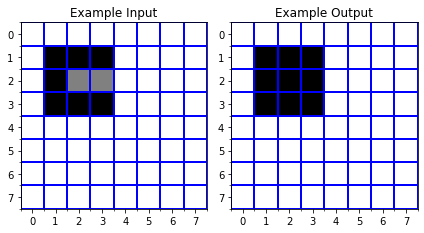

In [2]:


ex_square = np.ones((W, H), dtype=np.float32)
ex_square[1:4, 1:4] = 0.0

ex_cutout = ex_square.copy()
ex_cutout[2,2:4] = 0.5

# # Add noise
# img = clean_img + np.random.randn(*clean_img.shape)
# mn, mx = img.min(), img.max()

# Adjust contrast (equally to both images)
# img = (img - mn) / (mx - mn)
# clean_img = (clean_img - mn) / (mx - mn)

plt.figure()
plt.subplot(121)

plt.imshow(ex_cutout,cmap='gray')
plt.title('Example Input')

ax = plt.gca();
#https://stackoverflow.com/questions/38973868/adjusting-gridlines-and-ticks-in-matplotlib-imshow
# Major ticks
ax.set_xticks(np.arange(0, W, 1))
ax.set_yticks(np.arange(0, H, 1))

# Labels for major ticks
ax.set_xticklabels(np.arange(0, W, 1))
ax.set_yticklabels(np.arange(0, H, 1))

# Minor ticks
ax.set_xticks(np.arange(-.5, W, 1), minor=True)
ax.set_yticks(np.arange(-.5, H, 1), minor=True)

# Gridlines based on minor ticks
ax.grid(which='minor', color='b', linestyle='-', linewidth=2)




plt.subplot(122)
plt.imshow(ex_square,cmap='gray')
plt.title('Example Output')

ax = plt.gca();

# Major ticks
ax.set_xticks(np.arange(0, W, 1))
ax.set_yticks(np.arange(0, H, 1))

# Labels for major ticks
ax.set_xticklabels(np.arange(0, W, 1))
ax.set_yticklabels(np.arange(0, H, 1))

# Minor ticks
ax.set_xticks(np.arange(-.5, W, 1), minor=True)
ax.set_yticks(np.arange(-.5, H, 1), minor=True)

# Gridlines based on minor ticks
ax.grid(which='minor', color='b', linestyle='-', linewidth=2)

plt.tight_layout()

# Making a dataset of squares

In [3]:
#sz = size of square
ims = []
for sz in [2,3,4,5]:
    for i in range(0,W-(sz-1)):
        for j in range(0,H-(sz-1)):
            canvas = np.ones((W, H), dtype=np.float32)
            canvas[j:j+sz, i:i+sz] = 0.0
            ims.append(canvas)

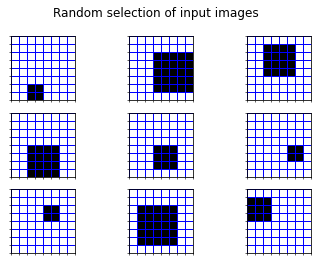

In [4]:
np.random.seed(2022)
im_count = np.arange(len(ims))
np.random.shuffle(im_count)
disp_ims = im_count[:9]
for itr in range(9):
    plt.subplot(3,3,itr+1)

    plt.imshow(ims[disp_ims[itr]],cmap='gray')

    ax = plt.gca();
    #https://stackoverflow.com/questions/38973868/adjusting-gridlines-and-ticks-in-matplotlib-imshow
    # Major ticks
    ax.set_xticks([])
    ax.set_yticks([])

    # Labels for major ticks
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    # Minor ticks
    ax.set_xticks(np.arange(-.5, W, 1), minor=True)
    ax.set_yticks(np.arange(-.5, H, 1), minor=True)
    
    # Gridlines based on minor ticks
    ax.grid(which='minor', color='b', linestyle='-', linewidth=1)

plt.suptitle('Random selection of input images');

# Create a masking function

In [5]:
def mask_im(im,r,mask_token_id):
    '''
    Creates a masked image
    '''
    sample = torch.rand(64).topk(r).indices

    mask = torch.zeros(64, dtype=torch.bool)
    mask.scatter_(dim=0, index=sample, value=True);

    masked_indices = mask_token_id * torch.ones(64)
    a_indices = mask * im + (~mask) * masked_indices
    return a_indices

Text(0.5, 0.98, 'Input images with random masking (20 percent)')

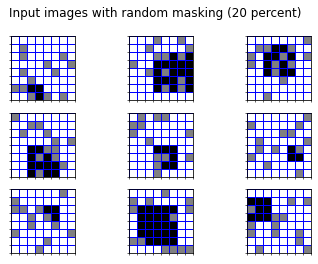

In [6]:
np.random.seed(2022)
for itr in range(9):
    plt.subplot(3,3,itr+1)
    r = int(.8*H*W)
    masked_im = mask_im(ims[disp_ims[itr]].flatten(),r,.5)
    plt.imshow(masked_im.reshape(H,W),cmap='gray')

    ax = plt.gca();
    #https://stackoverflow.com/questions/38973868/adjusting-gridlines-and-ticks-in-matplotlib-imshow
    # Major ticks
    ax.set_xticks([])
    ax.set_yticks([])

    # Labels for major ticks
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    # Minor ticks
    ax.set_xticks(np.arange(-.5, W, 1), minor=True)
    ax.set_yticks(np.arange(-.5, H, 1), minor=True)
    
    # Gridlines based on minor ticks
    ax.grid(which='minor', color='b', linestyle='-', linewidth=1)

plt.suptitle('Input images with random masking (20 percent)')

In [7]:
#meshgrid y and x
dev = 'cpu'
R = 1 #Patch size
y_pos, x_pos = torch.meshgrid([torch.linspace(0, H-1, H),torch.linspace(0, W-1, W)])

#dimensions (H*WX1)
x_pos = x_pos.flatten().unsqueeze(1)
y_pos = y_pos.flatten().unsqueeze(1)

c:\users\aneel\appdata\local\programs\python\python39\lib\site-packages\torch\functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [8]:
d_model = 200

def getPosEmbeddings(d_model=200,H=H,W=W):
  pe = torch.zeros(H*W, d_model).float()
#   pe = pe.to(x_pos.device)
  pe.require_grad = False

  torch.arange(0, H).float().unsqueeze(1)
  #Log form of classsic sinusoidal positional encoding
  div_term = (torch.arange(0, d_model/2, 2).float() * -(np.log(10000.0) / d_model)).exp()#.to(x_pos.device)

  #horizontal terms make up the first half of the positional encodings 
  pe[:, 0:pe.shape[1]//2:2] = torch.sin(x_pos * div_term)
  pe[:, 1:pe.shape[1]//2:2] = torch.cos(x_pos * div_term)
  #vertical terms make up the second half of the positional encodings
  pe[:, pe.shape[1]//2::2] = torch.sin(y_pos * div_term)
  pe[:, pe.shape[1]//2::2] = torch.cos(y_pos * div_term)
  return pe

pe = getPosEmbeddings()
pe.device

device(type='cpu')

## Notes on the codebook

Thankfully, this is built into pytorch in the ```nn.embedding``` function if 
you already know what your tokens are. If not, then you have to learn the optimal tokens for each patch.


Helpful sources:

*https://github.com/dome272/MaskGIT-pytorch/blob/main/codebook.py
https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html*


# Make the Bidirectional transformer

In [9]:
# https://github.com/dome272/MaskGIT-pytorch/blob/cff485ad3a14b6ed5f3aa966e045ea2bc8c68ad8/bidirectional_transformer.py#L106

def weights_init(m):
    classname = m.__class__.__name__
    if "Linear" in classname or "Embedding" == classname:
#         print(f"Initializing Module {classname}.")
        nn.init.trunc_normal_(m.weight.data, 0.0, 0.02)
    # elif "Parameter" in classname:
    #     return nn.init.trunc_normal_(m, 0.0, 0.02)

def mask_im(im,r,mask_token_id):
    '''
    Creates a masked image
    '''
    sample = torch.rand(im.shape[0], device=args.dev).topk(r).indices

    mask = torch.zeros(im.shape[0], dtype=torch.bool, device=args.dev)
    mask.scatter_(dim=0, index=sample, value=True);

    masked_indices = mask_token_id * torch.ones(64, device=args.dev)
    a_indices = mask * im + (~mask) * masked_indices
    a_indices = a_indices.type(torch.IntTensor)

    return a_indices

class Encoder(nn.Module):
    """
    Transformer encoder using MultiHeadAttention and MLP along with skip connections and LayerNorm
    """
    def __init__(self, dim=768, hidden_dim=3072):
        super(Encoder, self).__init__()
        self.MultiHeadAttention = nn.MultiheadAttention(dim, num_heads=8, dropout=0.1)
        self.LayerNorm1 = nn.LayerNorm(dim, eps=1e-12)
        self.LayerNorm2 = nn.LayerNorm(dim, eps=1e-12)
        self.MLP = nn.Sequential(*[
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(p=0.1)
        ])
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, x):
        attn, _ = self.MultiHeadAttention(x, x, x, need_weights=False)
        attn = self.dropout(attn)
        x = x.add(attn)
        x = self.LayerNorm1(x)
        mlp = self.MLP(x)
        x = x.add(mlp)
        x = self.LayerNorm2(x)
        return x


class BidirectionalTransformer(nn.Module):
    def __init__(self, args):
        super(BidirectionalTransformer, self).__init__()
        self.num_image_tokens = args.num_image_tokens

        # Embeddings of tokens (codes) and positions ( not learned)
        self.tok_emb = nn.Embedding(args.num_codebook_vectors + 1, args.dim,device = args.dev)
#         self.tok_emb = self.tok_emb.to(args.dev)
        self.pos_emb = getPosEmbeddings(d_model=args.dim).to(args.dev)


        # The actual transformer encoder architecutre
        self.blocks = nn.Sequential(*[Encoder(args.dim, args.hidden_dim) for _ in range(args.n_layers)])

        #Final 'MLP' to get predictions
#         self.Token_Prediction = nn.Sequential(*[
#             nn.Linear(in_features=args.dim, out_features=args.dim),
#             nn.GELU(),
#             nn.LayerNorm(args.dim, eps=1e-12)
#         ])
        
        self.Token_Prediction = nn.Sequential(*[
            nn.Linear(in_features=args.dim, out_features=args.dim),
            nn.GELU(),
            nn.LayerNorm(args.dim, eps=1e-12),
            nn.Linear(in_features=args.dim, out_features=args.num_codebook_vectors)
        ])
        self.bias = nn.Parameter(torch.zeros(self.num_image_tokens, args.num_codebook_vectors+1))
        self.ln = nn.LayerNorm(args.dim, eps=1e-12)
        self.drop = nn.Dropout(p=0.1)
        self.apply(weights_init)
        self.sm = nn.Softmax(dim = 1)

    def forward(self, x):

        token_embeddings = self.tok_emb(x)
        t = token_embeddings.shape[1]
        position_embeddings = self.pos_emb[:t, :]
        # position_embeddings = self.pos_emb(x)
        embed = self.drop(self.ln(token_embeddings + position_embeddings))
        embed = self.blocks(embed)
        out = self.Token_Prediction(embed)
#         out = torch.matmul(out, self.tok_emb.weight.T) + self.bias
        
        return out


# Implement the full quantized training step

In [10]:
class VQGANTransformer(nn.Module):
    def __init__(self, args):
        super(VQGANTransformer,self).__init__()
        self.num_image_tokens = args.num_image_tokens
        self.mask_token_id = args.num_codebook_vectors
        self.transformer = BidirectionalTransformer(args)
        
    def forward(self, im,training = True):
        
        if training:
            r = int(np.floor(np.cos(np.random.uniform() * np.pi/2)*self.num_image_tokens))
        else: 
            r = int(1)
        a_indices = mask_im(im,r,self.mask_token_id).to(args.dev)
        target = im.type(torch.LongTensor).to(args.dev)

        logits = self.transformer(a_indices)

        return logits, target

# Add a loss function and training loop

Also add a lr scheduler

https://github.com/dome272/MaskGIT-pytorch/blob/cff485ad3a14b6ed5f3aa966e045ea2bc8c68ad8/lr_schedule.py

In [11]:
from matplotlib import pyplot as plt
from torch import nn
from torch.optim import Adam


class WarmupLinearLRSchedule:
    """
    Implements Warmup learning rate schedule until 'warmup_steps', going from 'init_lr' to 'peak_lr' for multiple optimizers.
    """
    def __init__(self, optimizer, init_lr, peak_lr, end_lr, warmup_epochs, epochs=100, current_step=0):
        self.init_lr = init_lr
        self.peak_lr = peak_lr
        self.optimizer = optimizer
        self.warmup_rate = (peak_lr - init_lr) / warmup_epochs
        self.decay_rate = (end_lr - peak_lr) / (epochs - warmup_epochs)
        self.update_steps = current_step
        self.lr = init_lr
        self.warmup_steps = warmup_epochs
        self.epochs = epochs
        if current_step > 0:
            self.lr = self.peak_lr + self.decay_rate * (current_step - 1 - warmup_epochs)

    def set_lr(self, lr):
        print(f"Setting lr: {lr}")
        for g in self.optimizer.param_groups:
            g['lr'] = lr

    def step(self):
        if self.update_steps <= self.warmup_steps:
            lr = self.init_lr + self.warmup_rate * self.update_steps
        # elif self.warmup_steps < self.update_steps <= self.epochs:
        else:
            lr = max(0., self.lr + self.decay_rate)
        self.set_lr(lr)
        self.lr = lr
        self.update_steps += 1
        return self.lr

# Add code for converting images to torch tensors

In [12]:
def load_data(ims,args):
    tensor_list = torch.tensor(ims,dtype=torch.int,device=args.dev)
    return tensor_list.reshape(tensor_list.shape[0],-1)

In [13]:
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
from torchvision import utils as vutils
import os

class TrainTransformer:
    def __init__(self, ims, args):
        self.model = VQGANTransformer(args).to(device=args.dev)
        self.optim = torch.optim.Adam(self.model.transformer.parameters(), lr=1e-4, betas=(0.9, 0.96), weight_decay=4.5e-2)
        self.lr_schedule = WarmupLinearLRSchedule(
            optimizer=self.optim,
            init_lr=1e-6,
            peak_lr=args.learning_rate,
            end_lr=0.,
            warmup_epochs=10,
            epochs=args.epochs,
            current_step=args.start_from_epoch
        )
        self.ims = ims
        self.logger = SummaryWriter()
        
    def train(self, args):
        train_dataset = load_data(self.ims, args)
        len_train_dataset = len(train_dataset)
        step = 0
        for epoch in range(1, args.epochs+1):
            print(f"Epoch {epoch}:")
            with tqdm(range(len(train_dataset))) as pbar:
                self.lr_schedule.step()
                for i, imgs in zip(pbar, train_dataset):
                    imgs = imgs.to(device=args.dev)

                    logits, target = self.model(imgs)
                    loss = F.cross_entropy(logits.reshape(-1, logits.size(-1)), target.reshape(-1))
                    loss.backward()
                    if step % args.accum_grad == 0:
                        self.optim.step()
                        self.optim.zero_grad()
                    step += 1
                    pbar.set_postfix(Transformer_Loss=np.round(loss.cpu().detach().numpy().item(), 4))
                    pbar.update(0)
                    self.logger.add_scalar("Cross Entropy Loss", np.round(loss.cpu().detach().numpy().item(), 4), (epoch * len_train_dataset) + i)
            try:
                log, sampled_imgs = self.model.log_images(imgs[0:1])
                vutils.save_image(sampled_imgs.add(1).mul(0.5), os.path.join("results", f"{epoch}.jpg"), nrow=4)
            except:
                pass
#             torch.save(self.model.state_dict(), os.path.join("checkpoints", "transformer_current.pt"))

In [ ]:
trained_model = TrainTransformer(ims, args)
trained_model.train(args)

C:\Users\Aneel\AppData\Local\Temp/ipykernel_24696/3353636563.py:2: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  tensor_list = torch.tensor(ims,dtype=torch.int,device=args.dev)
C:\Users\Aneel\AppData\Local\Temp/ipykernel_24696/3353636563.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:204.)
  tensor_list = torch.tensor(ims,dtype=torch.int,device=args.dev)


Epoch 1:


  0%|          | 0/126 [00:00<?, ?it/s]

Setting lr: 1e-06


100%|██████████| 126/126 [00:05<00:00, 22.59it/s, Transformer_Loss=0.65] 


Epoch 2:


  2%|▏         | 3/126 [00:00<00:04, 29.99it/s, Transformer_Loss=0.567]

Setting lr: 1.09e-05


100%|██████████| 126/126 [00:05<00:00, 25.08it/s, Transformer_Loss=0.944]


Epoch 3:


  2%|▏         | 3/126 [00:00<00:07, 15.62it/s, Transformer_Loss=0.248]

Setting lr: 2.08e-05


100%|██████████| 126/126 [00:04<00:00, 26.16it/s, Transformer_Loss=0.745]


Epoch 4:


  2%|▏         | 3/126 [00:00<00:06, 19.35it/s, Transformer_Loss=0.33]

Setting lr: 3.07e-05


100%|██████████| 126/126 [00:04<00:00, 25.91it/s, Transformer_Loss=0.79] 


Epoch 5:


  2%|▏         | 3/126 [00:00<00:07, 15.46it/s, Transformer_Loss=0.305]

Setting lr: 4.06e-05


100%|██████████| 126/126 [00:04<00:00, 25.84it/s, Transformer_Loss=0.777]


Epoch 6:


  2%|▏         | 3/126 [00:00<00:07, 15.95it/s, Transformer_Loss=0.304]

Setting lr: 5.0499999999999994e-05


100%|██████████| 126/126 [00:04<00:00, 26.18it/s, Transformer_Loss=0.715]


Epoch 7:


  2%|▏         | 3/126 [00:00<00:07, 15.70it/s, Transformer_Loss=0.371]

Setting lr: 6.04e-05


100%|██████████| 126/126 [00:04<00:00, 26.61it/s, Transformer_Loss=0.705]


Epoch 8:


  2%|▏         | 3/126 [00:00<00:07, 16.04it/s, Transformer_Loss=0.362]

Setting lr: 7.03e-05


100%|██████████| 126/126 [00:04<00:00, 25.85it/s, Transformer_Loss=0.743]


Epoch 9:


  2%|▏         | 3/126 [00:00<00:08, 15.22it/s, Transformer_Loss=0.317]

Setting lr: 8.02e-05


100%|██████████| 126/126 [00:04<00:00, 26.11it/s, Transformer_Loss=0.699]


Epoch 10:


  2%|▏         | 3/126 [00:00<00:07, 15.87it/s, Transformer_Loss=0.388]

Setting lr: 9.01e-05


100%|██████████| 126/126 [00:04<00:00, 26.28it/s, Transformer_Loss=0.73] 


Epoch 11:


  2%|▏         | 3/126 [00:00<00:07, 16.13it/s, Transformer_Loss=0.332]

Setting lr: 9.999999999999999e-05


100%|██████████| 126/126 [00:04<00:00, 26.62it/s, Transformer_Loss=0.774]


Epoch 12:


  3%|▎         | 4/126 [00:00<00:05, 21.86it/s, Transformer_Loss=0.294]

Setting lr: 9.997995991983967e-05


100%|██████████| 126/126 [00:04<00:00, 26.42it/s, Transformer_Loss=0.703]


Epoch 13:


  3%|▎         | 4/126 [00:00<00:05, 21.74it/s, Transformer_Loss=0.362]

Setting lr: 9.995991983967936e-05


100%|██████████| 126/126 [00:04<00:00, 26.24it/s, Transformer_Loss=0.722]


Epoch 14:


  2%|▏         | 3/126 [00:00<00:07, 15.62it/s, Transformer_Loss=0.31] 

Setting lr: 9.993987975951904e-05


100%|██████████| 126/126 [00:04<00:00, 26.05it/s, Transformer_Loss=0.752]


Epoch 15:


  2%|▏         | 3/126 [00:00<00:07, 16.39it/s, Transformer_Loss=0.313]

Setting lr: 9.991983967935872e-05


100%|██████████| 126/126 [00:04<00:00, 25.63it/s, Transformer_Loss=0.677]


Epoch 16:


  2%|▏         | 2/126 [00:00<00:12,  9.85it/s, Transformer_Loss=0.352]

Setting lr: 9.98997995991984e-05


100%|██████████| 126/126 [00:04<00:00, 26.29it/s, Transformer_Loss=0.728]


Epoch 17:


  2%|▏         | 3/126 [00:00<00:07, 16.04it/s, Transformer_Loss=0.294]

Setting lr: 9.987975951903809e-05


100%|██████████| 126/126 [00:04<00:00, 26.16it/s, Transformer_Loss=0.608]


Epoch 18:


  2%|▏         | 3/126 [00:00<00:07, 15.62it/s, Transformer_Loss=0.436]

Setting lr: 9.985971943887777e-05


100%|██████████| 126/126 [00:04<00:00, 26.28it/s, Transformer_Loss=0.603]


Epoch 19:


  2%|▏         | 3/126 [00:00<00:07, 16.04it/s, Transformer_Loss=0.271]

Setting lr: 9.983967935871745e-05


100%|██████████| 126/126 [00:04<00:00, 26.19it/s, Transformer_Loss=0.47] 


Epoch 20:


  2%|▏         | 3/126 [00:00<00:07, 16.04it/s, Transformer_Loss=0.283]

Setting lr: 9.981963927855713e-05


100%|██████████| 126/126 [00:04<00:00, 26.17it/s, Transformer_Loss=0.408]


Epoch 21:


  2%|▏         | 3/126 [00:00<00:07, 15.38it/s, Transformer_Loss=0.497]

Setting lr: 9.979959919839682e-05


100%|██████████| 126/126 [00:05<00:00, 25.18it/s, Transformer_Loss=0.362]


Epoch 22:


  2%|▏         | 3/126 [00:00<00:07, 15.62it/s, Transformer_Loss=0.481]

Setting lr: 9.97795591182365e-05


100%|██████████| 126/126 [00:04<00:00, 26.42it/s, Transformer_Loss=0.635]


Epoch 23:


  2%|▏         | 3/126 [00:00<00:07, 16.13it/s, Transformer_Loss=0.38] 

Setting lr: 9.975951903807618e-05


100%|██████████| 126/126 [00:04<00:00, 26.34it/s, Transformer_Loss=0.702]


Epoch 24:


  2%|▏         | 3/126 [00:00<00:07, 16.13it/s, Transformer_Loss=0.231]

Setting lr: 9.973947895791586e-05


100%|██████████| 126/126 [00:04<00:00, 26.47it/s, Transformer_Loss=0.27] 


Epoch 25:


  2%|▏         | 3/126 [00:00<00:07, 15.70it/s, Transformer_Loss=0.176]

Setting lr: 9.971943887775555e-05


100%|██████████| 126/126 [00:04<00:00, 26.28it/s, Transformer_Loss=0.506] 


Epoch 26:


  2%|▏         | 3/126 [00:00<00:07, 15.87it/s, Transformer_Loss=0.105]

Setting lr: 9.969939879759523e-05


100%|██████████| 126/126 [00:04<00:00, 26.10it/s, Transformer_Loss=0.228]


Epoch 27:


  2%|▏         | 3/126 [00:00<00:05, 21.58it/s, Transformer_Loss=0.131]

Setting lr: 9.967935871743491e-05


100%|██████████| 126/126 [00:05<00:00, 25.19it/s, Transformer_Loss=0.584] 


Epoch 28:


  2%|▏         | 3/126 [00:00<00:08, 15.30it/s, Transformer_Loss=0.0909]

Setting lr: 9.96593186372746e-05


100%|██████████| 126/126 [00:04<00:00, 25.40it/s, Transformer_Loss=0.249] 


Epoch 29:


  2%|▏         | 3/126 [00:00<00:07, 15.62it/s, Transformer_Loss=0.319] 

Setting lr: 9.963927855711428e-05


100%|██████████| 126/126 [00:05<00:00, 25.10it/s, Transformer_Loss=0.835] 


Epoch 30:


  2%|▏         | 3/126 [00:00<00:06, 18.86it/s, Transformer_Loss=0.129]

Setting lr: 9.961923847695396e-05


100%|██████████| 126/126 [00:05<00:00, 25.16it/s, Transformer_Loss=0.0956]


Epoch 31:


  2%|▏         | 3/126 [00:00<00:08, 15.22it/s, Transformer_Loss=0.23]  

Setting lr: 9.959919839679364e-05


100%|██████████| 126/126 [00:04<00:00, 25.51it/s, Transformer_Loss=0.205] 


Epoch 32:


  2%|▏         | 3/126 [00:00<00:08, 15.23it/s, Transformer_Loss=0.264]

Setting lr: 9.957915831663333e-05


100%|██████████| 126/126 [00:04<00:00, 25.71it/s, Transformer_Loss=0.085] 


Epoch 33:


  2%|▏         | 3/126 [00:00<00:07, 16.96it/s, Transformer_Loss=0.311]

Setting lr: 9.955911823647301e-05


100%|██████████| 126/126 [00:05<00:00, 24.77it/s, Transformer_Loss=0.627] 


Epoch 34:


  2%|▏         | 3/126 [00:00<00:07, 15.46it/s, Transformer_Loss=0.368]

Setting lr: 9.953907815631269e-05


100%|██████████| 126/126 [00:04<00:00, 25.61it/s, Transformer_Loss=0.288] 


Epoch 35:


  2%|▏         | 3/126 [00:00<00:07, 15.66it/s, Transformer_Loss=0.11] 

Setting lr: 9.951903807615237e-05


100%|██████████| 126/126 [00:05<00:00, 25.19it/s, Transformer_Loss=0.555] 


Epoch 36:


  2%|▏         | 3/126 [00:00<00:07, 15.87it/s, Transformer_Loss=0.0641]

Setting lr: 9.949899799599206e-05


100%|██████████| 126/126 [00:04<00:00, 25.24it/s, Transformer_Loss=0.877] 


Epoch 37:


  3%|▎         | 4/126 [00:00<00:05, 21.50it/s, Transformer_Loss=0.302]

Setting lr: 9.947895791583174e-05


100%|██████████| 126/126 [00:04<00:00, 25.23it/s, Transformer_Loss=0.802] 


Epoch 38:


  2%|▏         | 3/126 [00:00<00:06, 18.63it/s, Transformer_Loss=0.183]

Setting lr: 9.945891783567142e-05


100%|██████████| 126/126 [00:04<00:00, 25.72it/s, Transformer_Loss=0.769] 


Epoch 39:


  2%|▏         | 3/126 [00:00<00:07, 15.79it/s, Transformer_Loss=0.25] 

Setting lr: 9.94388777555111e-05


100%|██████████| 126/126 [00:04<00:00, 25.96it/s, Transformer_Loss=0.159] 


Epoch 40:


  2%|▏         | 3/126 [00:00<00:08, 14.92it/s, Transformer_Loss=0.276]

Setting lr: 9.941883767535079e-05


100%|██████████| 126/126 [00:04<00:00, 25.48it/s, Transformer_Loss=0.059] 


Epoch 41:


  2%|▏         | 2/126 [00:00<00:06, 20.00it/s, Transformer_Loss=0.138] 

Setting lr: 9.939879759519047e-05


100%|██████████| 126/126 [00:05<00:00, 24.83it/s, Transformer_Loss=0.183] 


Epoch 42:


  2%|▏         | 3/126 [00:00<00:07, 16.21it/s, Transformer_Loss=0.242]

Setting lr: 9.937875751503015e-05


100%|██████████| 126/126 [00:04<00:00, 25.51it/s, Transformer_Loss=0.244] 


Epoch 43:


  2%|▏         | 3/126 [00:00<00:08, 15.15it/s, Transformer_Loss=0.279]

Setting lr: 9.935871743486983e-05


100%|██████████| 126/126 [00:04<00:00, 25.87it/s, Transformer_Loss=0.141] 


Epoch 44:


  2%|▏         | 3/126 [00:00<00:07, 15.87it/s, Transformer_Loss=0.252]

Setting lr: 9.933867735470952e-05


100%|██████████| 126/126 [00:05<00:00, 24.92it/s, Transformer_Loss=0.364] 


Epoch 45:


  2%|▏         | 3/126 [00:00<00:07, 15.62it/s, Transformer_Loss=0.0914]

Setting lr: 9.93186372745492e-05


100%|██████████| 126/126 [00:04<00:00, 25.30it/s, Transformer_Loss=0.0388]


Epoch 46:


  2%|▏         | 3/126 [00:00<00:07, 16.21it/s, Transformer_Loss=0.075] 

Setting lr: 9.929859719438888e-05


100%|██████████| 126/126 [00:04<00:00, 25.41it/s, Transformer_Loss=0.347] 


Epoch 47:


  3%|▎         | 4/126 [00:00<00:05, 21.05it/s, Transformer_Loss=0.0678]

Setting lr: 9.927855711422856e-05


100%|██████████| 126/126 [00:04<00:00, 25.38it/s, Transformer_Loss=0.641] 


Epoch 48:


  2%|▏         | 3/126 [00:00<00:07, 17.54it/s, Transformer_Loss=0.0636]

Setting lr: 9.925851703406825e-05


100%|██████████| 126/126 [00:04<00:00, 25.70it/s, Transformer_Loss=0.301] 


Epoch 49:


  2%|▏         | 3/126 [00:00<00:08, 15.15it/s, Transformer_Loss=0.107]

Setting lr: 9.923847695390793e-05


100%|██████████| 126/126 [00:05<00:00, 25.00it/s, Transformer_Loss=0.739] 


Epoch 50:


  2%|▏         | 3/126 [00:00<00:06, 18.18it/s, Transformer_Loss=0.266]

Setting lr: 9.921843687374761e-05


100%|██████████| 126/126 [00:04<00:00, 25.66it/s, Transformer_Loss=0.144] 


Epoch 51:


  2%|▏         | 3/126 [00:00<00:07, 15.62it/s, Transformer_Loss=0.15] 

Setting lr: 9.91983967935873e-05


100%|██████████| 126/126 [00:04<00:00, 25.41it/s, Transformer_Loss=0.684] 


Epoch 52:


  3%|▎         | 4/126 [00:00<00:05, 20.40it/s, Transformer_Loss=0.0457]

Setting lr: 9.917835671342698e-05


100%|██████████| 126/126 [00:04<00:00, 25.52it/s, Transformer_Loss=0.147] 


Epoch 53:


  2%|▏         | 3/126 [00:00<00:06, 17.85it/s, Transformer_Loss=0.185]

Setting lr: 9.915831663326666e-05


100%|██████████| 126/126 [00:04<00:00, 25.56it/s, Transformer_Loss=0.0653]


Epoch 54:


  2%|▏         | 3/126 [00:00<00:08, 15.15it/s, Transformer_Loss=0.392]

Setting lr: 9.913827655310634e-05


100%|██████████| 126/126 [00:04<00:00, 25.45it/s, Transformer_Loss=0.18]  


Epoch 55:


  2%|▏         | 3/126 [00:00<00:06, 18.75it/s, Transformer_Loss=0.121]

Setting lr: 9.911823647294602e-05


100%|██████████| 126/126 [00:05<00:00, 25.03it/s, Transformer_Loss=0.0416]


Epoch 56:


  2%|▏         | 3/126 [00:00<00:06, 17.64it/s, Transformer_Loss=0.107]

Setting lr: 9.90981963927857e-05


100%|██████████| 126/126 [00:04<00:00, 25.63it/s, Transformer_Loss=0.812] 


Epoch 57:


  2%|▏         | 3/126 [00:00<00:07, 15.95it/s, Transformer_Loss=0.0596]

Setting lr: 9.907815631262539e-05


100%|██████████| 126/126 [00:04<00:00, 25.28it/s, Transformer_Loss=0.157] 


Epoch 58:


  2%|▏         | 3/126 [00:00<00:08, 14.35it/s, Transformer_Loss=0.216]

Setting lr: 9.905811623246507e-05


100%|██████████| 126/126 [00:04<00:00, 25.42it/s, Transformer_Loss=0.438] 


Epoch 59:


  2%|▏         | 3/126 [00:00<00:07, 15.54it/s, Transformer_Loss=0.209]

Setting lr: 9.903807615230475e-05


100%|██████████| 126/126 [00:04<00:00, 25.81it/s, Transformer_Loss=0.0416]


Epoch 60:


  2%|▏         | 3/126 [00:00<00:08, 15.15it/s, Transformer_Loss=0.0588]

Setting lr: 9.901803607214444e-05


100%|██████████| 126/126 [00:04<00:00, 25.96it/s, Transformer_Loss=0.558] 


Epoch 61:


  2%|▏         | 3/126 [00:00<00:08, 14.92it/s, Transformer_Loss=0.155] 

Setting lr: 9.899799599198412e-05


100%|██████████| 126/126 [00:04<00:00, 25.31it/s, Transformer_Loss=0.232] 


Epoch 62:


  3%|▎         | 4/126 [00:00<00:05, 22.59it/s, Transformer_Loss=0.206]

Setting lr: 9.89779559118238e-05


100%|██████████| 126/126 [00:04<00:00, 25.89it/s, Transformer_Loss=0.235] 


Epoch 63:


  2%|▏         | 3/126 [00:00<00:08, 15.15it/s, Transformer_Loss=0.203]

Setting lr: 9.895791583166348e-05


100%|██████████| 126/126 [00:04<00:00, 25.60it/s, Transformer_Loss=0.673] 


Epoch 64:


  2%|▏         | 3/126 [00:00<00:07, 15.54it/s, Transformer_Loss=0.357] 

Setting lr: 9.893787575150317e-05


100%|██████████| 126/126 [00:04<00:00, 25.90it/s, Transformer_Loss=0.706] 


Epoch 65:


  2%|▏         | 3/126 [00:00<00:07, 15.87it/s, Transformer_Loss=0.267]

Setting lr: 9.891783567134285e-05


100%|██████████| 126/126 [00:04<00:00, 25.69it/s, Transformer_Loss=0.0787]


Epoch 66:


  2%|▏         | 3/126 [00:00<00:08, 14.49it/s, Transformer_Loss=0.0994]

Setting lr: 9.889779559118253e-05


100%|██████████| 126/126 [00:04<00:00, 25.51it/s, Transformer_Loss=0.537] 


Epoch 67:


  2%|▏         | 3/126 [00:00<00:08, 14.77it/s, Transformer_Loss=0.0758]

Setting lr: 9.887775551102221e-05


100%|██████████| 126/126 [00:04<00:00, 25.53it/s, Transformer_Loss=0.0174]


Epoch 68:


  2%|▏         | 3/126 [00:00<00:08, 14.85it/s, Transformer_Loss=0.165] 

Setting lr: 9.88577154308619e-05


100%|██████████| 126/126 [00:04<00:00, 25.53it/s, Transformer_Loss=0.058] 


Epoch 69:


  2%|▏         | 3/126 [00:00<00:08, 15.23it/s, Transformer_Loss=0.274] 

Setting lr: 9.883767535070158e-05


100%|██████████| 126/126 [00:04<00:00, 25.70it/s, Transformer_Loss=0.322] 


Epoch 70:


  2%|▏         | 3/126 [00:00<00:07, 16.13it/s, Transformer_Loss=0.216]

Setting lr: 9.881763527054126e-05


100%|██████████| 126/126 [00:04<00:00, 25.22it/s, Transformer_Loss=0.609] 


Epoch 71:


  2%|▏         | 3/126 [00:00<00:07, 15.46it/s, Transformer_Loss=0.0507]

Setting lr: 9.879759519038095e-05


100%|██████████| 126/126 [00:04<00:00, 25.90it/s, Transformer_Loss=0.243] 


Epoch 72:


  2%|▏         | 3/126 [00:00<00:08, 14.85it/s, Transformer_Loss=0.132] 

Setting lr: 9.877755511022063e-05


100%|██████████| 126/126 [00:04<00:00, 25.49it/s, Transformer_Loss=0.0665]


Epoch 73:


  2%|▏         | 3/126 [00:00<00:07, 15.70it/s, Transformer_Loss=0.178] 

Setting lr: 9.875751503006031e-05


100%|██████████| 126/126 [00:04<00:00, 25.44it/s, Transformer_Loss=0.48]  


Epoch 74:


  2%|▏         | 3/126 [00:00<00:08, 15.30it/s, Transformer_Loss=0.195] 

Setting lr: 9.873747494989999e-05


100%|██████████| 126/126 [00:04<00:00, 25.64it/s, Transformer_Loss=0.262] 


Epoch 75:


  2%|▏         | 3/126 [00:00<00:07, 16.21it/s, Transformer_Loss=0.177]

Setting lr: 9.871743486973968e-05


100%|██████████| 126/126 [00:04<00:00, 25.74it/s, Transformer_Loss=0.499] 


Epoch 76:


  2%|▏         | 2/126 [00:00<00:12,  9.57it/s, Transformer_Loss=0.32]  

Setting lr: 9.869739478957936e-05


100%|██████████| 126/126 [00:04<00:00, 25.46it/s, Transformer_Loss=0.059] 


Epoch 77:


  2%|▏         | 3/126 [00:00<00:07, 15.87it/s, Transformer_Loss=0.0337]

Setting lr: 9.867735470941904e-05


100%|██████████| 126/126 [00:04<00:00, 25.51it/s, Transformer_Loss=0.281] 


Epoch 78:


  3%|▎         | 4/126 [00:00<00:05, 21.16it/s, Transformer_Loss=0.117]

Setting lr: 9.865731462925872e-05


100%|██████████| 126/126 [00:04<00:00, 25.68it/s, Transformer_Loss=0.0233]


Epoch 79:


  2%|▏         | 3/126 [00:00<00:07, 15.38it/s, Transformer_Loss=0.185] 

Setting lr: 9.86372745490984e-05


100%|██████████| 126/126 [00:04<00:00, 25.58it/s, Transformer_Loss=0.698] 


Epoch 80:


  2%|▏         | 3/126 [00:00<00:06, 18.51it/s, Transformer_Loss=0.21]

Setting lr: 9.861723446893809e-05


100%|██████████| 126/126 [00:04<00:00, 25.77it/s, Transformer_Loss=0.0914]


Epoch 81:


  2%|▏         | 3/126 [00:00<00:07, 15.54it/s, Transformer_Loss=0.148]

Setting lr: 9.859719438877777e-05


100%|██████████| 126/126 [00:04<00:00, 25.42it/s, Transformer_Loss=0.0621]


Epoch 82:


  2%|▏         | 3/126 [00:00<00:07, 15.87it/s, Transformer_Loss=0.0563]

Setting lr: 9.857715430861745e-05


100%|██████████| 126/126 [00:04<00:00, 25.30it/s, Transformer_Loss=0.0397]


Epoch 83:


  2%|▏         | 3/126 [00:00<00:08, 15.15it/s, Transformer_Loss=0.0417]

Setting lr: 9.855711422845714e-05


100%|██████████| 126/126 [00:04<00:00, 25.36it/s, Transformer_Loss=0.728] 


Epoch 84:


  2%|▏         | 3/126 [00:00<00:07, 16.04it/s, Transformer_Loss=0.0898]

Setting lr: 9.853707414829682e-05


100%|██████████| 126/126 [00:04<00:00, 25.62it/s, Transformer_Loss=0.0177]


Epoch 85:


  2%|▏         | 3/126 [00:00<00:06, 18.51it/s, Transformer_Loss=0.169]

Setting lr: 9.85170340681365e-05


100%|██████████| 126/126 [00:04<00:00, 25.40it/s, Transformer_Loss=0.0225]


Epoch 86:


  2%|▏         | 3/126 [00:00<00:07, 15.46it/s, Transformer_Loss=0.0157]

Setting lr: 9.849699398797618e-05


100%|██████████| 126/126 [00:04<00:00, 25.58it/s, Transformer_Loss=0.563] 


Epoch 87:


  2%|▏         | 3/126 [00:00<00:05, 22.22it/s, Transformer_Loss=0.11]

Setting lr: 9.847695390781587e-05


100%|██████████| 126/126 [00:04<00:00, 25.27it/s, Transformer_Loss=0.229] 


Epoch 88:


  2%|▏         | 3/126 [00:00<00:07, 15.95it/s, Transformer_Loss=0.356] 

Setting lr: 9.845691382765555e-05


100%|██████████| 126/126 [00:04<00:00, 25.51it/s, Transformer_Loss=0.138] 


Epoch 89:


  2%|▏         | 3/126 [00:00<00:07, 15.62it/s, Transformer_Loss=0.249] 

Setting lr: 9.843687374749523e-05


100%|██████████| 126/126 [00:04<00:00, 25.42it/s, Transformer_Loss=0.574] 


Epoch 90:


  2%|▏         | 3/126 [00:00<00:06, 17.96it/s, Transformer_Loss=0.0798]

Setting lr: 9.841683366733491e-05


100%|██████████| 126/126 [00:04<00:00, 25.51it/s, Transformer_Loss=0.178] 


Epoch 91:


  2%|▏         | 3/126 [00:00<00:07, 16.04it/s, Transformer_Loss=0.161]

Setting lr: 9.83967935871746e-05


100%|██████████| 126/126 [00:04<00:00, 25.53it/s, Transformer_Loss=0.0207]


Epoch 92:


  3%|▎         | 4/126 [00:00<00:05, 21.97it/s, Transformer_Loss=0.231]

Setting lr: 9.837675350701428e-05


100%|██████████| 126/126 [00:04<00:00, 25.74it/s, Transformer_Loss=0.5]   


Epoch 93:


  2%|▏         | 3/126 [00:00<00:06, 18.29it/s, Transformer_Loss=0.141]

Setting lr: 9.835671342685396e-05


100%|██████████| 126/126 [00:05<00:00, 24.80it/s, Transformer_Loss=0.0532]


Epoch 94:


  2%|▏         | 3/126 [00:00<00:07, 16.30it/s, Transformer_Loss=0.139] 

Setting lr: 9.833667334669364e-05


100%|██████████| 126/126 [00:04<00:00, 25.82it/s, Transformer_Loss=0.0414]


Epoch 95:


  2%|▏         | 3/126 [00:00<00:08, 15.30it/s, Transformer_Loss=0.316]

Setting lr: 9.831663326653333e-05


100%|██████████| 126/126 [00:05<00:00, 24.83it/s, Transformer_Loss=0.241] 


Epoch 96:


  2%|▏         | 3/126 [00:00<00:07, 15.79it/s, Transformer_Loss=0.0246]

Setting lr: 9.829659318637301e-05


100%|██████████| 126/126 [00:04<00:00, 25.61it/s, Transformer_Loss=0.503] 


Epoch 97:


  3%|▎         | 4/126 [00:00<00:06, 18.43it/s, Transformer_Loss=0.0292]

Setting lr: 9.827655310621269e-05


100%|██████████| 126/126 [00:04<00:00, 25.27it/s, Transformer_Loss=0.0178]


Epoch 98:


  2%|▏         | 3/126 [00:00<00:07, 15.62it/s, Transformer_Loss=0.188]

Setting lr: 9.825651302605237e-05


100%|██████████| 126/126 [00:04<00:00, 25.60it/s, Transformer_Loss=0.622] 


Epoch 99:


  2%|▏         | 3/126 [00:00<00:08, 15.30it/s, Transformer_Loss=0.0951]

Setting lr: 9.823647294589206e-05


100%|██████████| 126/126 [00:04<00:00, 25.62it/s, Transformer_Loss=0.638] 


Epoch 100:


  2%|▏         | 3/126 [00:00<00:08, 15.07it/s, Transformer_Loss=0.0216]

Setting lr: 9.821643286573174e-05


100%|██████████| 126/126 [00:04<00:00, 25.51it/s, Transformer_Loss=0.0176]


Epoch 101:


  2%|▏         | 3/126 [00:00<00:07, 15.54it/s, Transformer_Loss=0.146] 

Setting lr: 9.819639278557142e-05


100%|██████████| 126/126 [00:04<00:00, 25.26it/s, Transformer_Loss=0.172] 


Epoch 102:


  2%|▏         | 3/126 [00:00<00:08, 15.15it/s, Transformer_Loss=0.133] 

Setting lr: 9.81763527054111e-05


100%|██████████| 126/126 [00:04<00:00, 25.84it/s, Transformer_Loss=0.5]   


Epoch 103:


  2%|▏         | 3/126 [00:00<00:07, 16.30it/s, Transformer_Loss=0.17] 

Setting lr: 9.815631262525079e-05


100%|██████████| 126/126 [00:05<00:00, 25.13it/s, Transformer_Loss=0.414] 


Epoch 104:


  2%|▏         | 3/126 [00:00<00:07, 16.13it/s, Transformer_Loss=0.0322]

Setting lr: 9.813627254509047e-05


100%|██████████| 126/126 [00:04<00:00, 25.89it/s, Transformer_Loss=0.711] 


Epoch 105:


  2%|▏         | 2/126 [00:00<00:11, 10.99it/s, Transformer_Loss=0.0308]

Setting lr: 9.811623246493015e-05


100%|██████████| 126/126 [00:05<00:00, 24.87it/s, Transformer_Loss=0.159] 


Epoch 106:


  2%|▏         | 3/126 [00:00<00:07, 16.48it/s, Transformer_Loss=0.045]

Setting lr: 9.809619238476983e-05


100%|██████████| 126/126 [00:05<00:00, 25.13it/s, Transformer_Loss=0.603] 


Epoch 107:


  2%|▏         | 3/126 [00:00<00:06, 19.10it/s, Transformer_Loss=0.0136]

Setting lr: 9.807615230460952e-05


100%|██████████| 126/126 [00:05<00:00, 25.11it/s, Transformer_Loss=0.0899]


Epoch 108:


  2%|▏         | 3/126 [00:00<00:07, 16.13it/s, Transformer_Loss=0.153] 

Setting lr: 9.80561122244492e-05


100%|██████████| 126/126 [00:04<00:00, 25.65it/s, Transformer_Loss=0.176] 


Epoch 109:


  2%|▏         | 3/126 [00:00<00:07, 16.39it/s, Transformer_Loss=0.231]

Setting lr: 9.803607214428888e-05


100%|██████████| 126/126 [00:04<00:00, 25.87it/s, Transformer_Loss=0.0261]


Epoch 110:


  2%|▏         | 3/126 [00:00<00:08, 14.49it/s, Transformer_Loss=0.311]

Setting lr: 9.801603206412857e-05


100%|██████████| 126/126 [00:04<00:00, 26.00it/s, Transformer_Loss=0.249] 


Epoch 111:


  2%|▏         | 3/126 [00:00<00:07, 16.66it/s, Transformer_Loss=0.101] 

Setting lr: 9.799599198396825e-05


100%|██████████| 126/126 [00:04<00:00, 25.63it/s, Transformer_Loss=0.021] 


Epoch 112:


  3%|▎         | 4/126 [00:00<00:05, 21.73it/s, Transformer_Loss=0.234]

Setting lr: 9.797595190380793e-05


100%|██████████| 126/126 [00:04<00:00, 25.47it/s, Transformer_Loss=0.476] 


Epoch 113:


  2%|▏         | 3/126 [00:00<00:08, 15.30it/s, Transformer_Loss=0.307]

Setting lr: 9.795591182364761e-05


100%|██████████| 126/126 [00:04<00:00, 25.38it/s, Transformer_Loss=0.539] 


Epoch 114:


  2%|▏         | 3/126 [00:00<00:06, 18.18it/s, Transformer_Loss=0.163]

Setting lr: 9.79358717434873e-05


100%|██████████| 126/126 [00:04<00:00, 25.23it/s, Transformer_Loss=0.722] 


Epoch 115:


  2%|▏         | 3/126 [00:00<00:08, 15.15it/s, Transformer_Loss=0.233] 

Setting lr: 9.791583166332698e-05


100%|██████████| 126/126 [00:04<00:00, 25.79it/s, Transformer_Loss=0.163] 


Epoch 116:


  2%|▏         | 3/126 [00:00<00:08, 15.22it/s, Transformer_Loss=0.372] 

Setting lr: 9.789579158316666e-05


100%|██████████| 126/126 [00:04<00:00, 25.47it/s, Transformer_Loss=0.402] 


Epoch 117:


  3%|▎         | 4/126 [00:00<00:05, 21.05it/s, Transformer_Loss=0.0341]

Setting lr: 9.787575150300634e-05


100%|██████████| 126/126 [00:04<00:00, 25.40it/s, Transformer_Loss=0.0535]


Epoch 118:


  2%|▏         | 3/126 [00:00<00:07, 16.21it/s, Transformer_Loss=0.0887]

Setting lr: 9.785571142284603e-05


100%|██████████| 126/126 [00:04<00:00, 25.52it/s, Transformer_Loss=0.185] 


Epoch 119:


  2%|▏         | 3/126 [00:00<00:08, 14.08it/s, Transformer_Loss=0.304] 

Setting lr: 9.783567134268571e-05


100%|██████████| 126/126 [00:04<00:00, 25.88it/s, Transformer_Loss=0.0963]


Epoch 120:


  2%|▏         | 3/126 [00:00<00:07, 16.13it/s, Transformer_Loss=0.135] 

Setting lr: 9.781563126252539e-05


100%|██████████| 126/126 [00:04<00:00, 25.48it/s, Transformer_Loss=0.0243]


Epoch 121:


  2%|▏         | 3/126 [00:00<00:07, 15.70it/s, Transformer_Loss=0.316]

Setting lr: 9.779559118236507e-05


100%|██████████| 126/126 [00:04<00:00, 25.43it/s, Transformer_Loss=0.0772]


Epoch 122:


  3%|▎         | 4/126 [00:00<00:05, 21.97it/s, Transformer_Loss=0.0251]

Setting lr: 9.777555110220476e-05


100%|██████████| 126/126 [00:04<00:00, 25.81it/s, Transformer_Loss=0.0393]


Epoch 123:


  2%|▏         | 3/126 [00:00<00:08, 14.42it/s, Transformer_Loss=0.203]

Setting lr: 9.775551102204444e-05


100%|██████████| 126/126 [00:04<00:00, 25.61it/s, Transformer_Loss=0.0216]


Epoch 124:


  2%|▏         | 3/126 [00:00<00:07, 15.46it/s, Transformer_Loss=0.149] 

Setting lr: 9.773547094188412e-05


100%|██████████| 126/126 [00:04<00:00, 25.79it/s, Transformer_Loss=0.0286]


Epoch 125:


  2%|▏         | 3/126 [00:00<00:07, 16.30it/s, Transformer_Loss=0.0255]

Setting lr: 9.77154308617238e-05


100%|██████████| 126/126 [00:04<00:00, 25.60it/s, Transformer_Loss=0.529] 


Epoch 126:


  2%|▏         | 3/126 [00:00<00:07, 15.62it/s, Transformer_Loss=0.165] 

Setting lr: 9.769539078156349e-05


100%|██████████| 126/126 [00:04<00:00, 25.43it/s, Transformer_Loss=0.63]  


Epoch 127:


  3%|▎         | 4/126 [00:00<00:05, 22.47it/s, Transformer_Loss=0.188]

Setting lr: 9.767535070140317e-05


100%|██████████| 126/126 [00:04<00:00, 25.27it/s, Transformer_Loss=0.287] 


Epoch 128:


  2%|▏         | 3/126 [00:00<00:07, 15.54it/s, Transformer_Loss=0.212] 

Setting lr: 9.765531062124285e-05


100%|██████████| 126/126 [00:04<00:00, 25.76it/s, Transformer_Loss=0.0848]


Epoch 129:


  2%|▏         | 3/126 [00:00<00:08, 15.30it/s, Transformer_Loss=0.0089]

Setting lr: 9.763527054108253e-05


100%|██████████| 126/126 [00:04<00:00, 25.62it/s, Transformer_Loss=0.109] 


Epoch 130:


  2%|▏         | 3/126 [00:00<00:08, 15.30it/s, Transformer_Loss=0.296]

Setting lr: 9.761523046092222e-05


100%|██████████| 126/126 [00:04<00:00, 25.66it/s, Transformer_Loss=0.685] 


Epoch 131:


  2%|▏         | 3/126 [00:00<00:07, 15.70it/s, Transformer_Loss=0.244] 

Setting lr: 9.75951903807619e-05


100%|██████████| 126/126 [00:04<00:00, 25.32it/s, Transformer_Loss=0.164] 


Epoch 132:


  2%|▏         | 3/126 [00:00<00:07, 16.48it/s, Transformer_Loss=0.0634]

Setting lr: 9.757515030060158e-05


100%|██████████| 126/126 [00:04<00:00, 25.71it/s, Transformer_Loss=0.0561]


Epoch 133:


  3%|▎         | 4/126 [00:00<00:05, 20.61it/s, Transformer_Loss=0.0354]

Setting lr: 9.755511022044126e-05


100%|██████████| 126/126 [00:04<00:00, 25.50it/s, Transformer_Loss=0.164] 


Epoch 134:


  2%|▏         | 3/126 [00:00<00:06, 19.23it/s, Transformer_Loss=0.0108]

Setting lr: 9.753507014028095e-05


100%|██████████| 126/126 [00:04<00:00, 25.80it/s, Transformer_Loss=0.687] 


Epoch 135:


  2%|▏         | 3/126 [00:00<00:07, 16.48it/s, Transformer_Loss=0.0554]

Setting lr: 9.751503006012063e-05


100%|██████████| 126/126 [00:04<00:00, 25.72it/s, Transformer_Loss=0.0275]


Epoch 136:


  2%|▏         | 3/126 [00:00<00:07, 15.95it/s, Transformer_Loss=0.0241]

Setting lr: 9.749498997996031e-05


100%|██████████| 126/126 [00:04<00:00, 25.37it/s, Transformer_Loss=0.0262]


Epoch 137:


  2%|▏         | 3/126 [00:00<00:08, 15.15it/s, Transformer_Loss=0.0121]

Setting lr: 9.74749498998e-05


100%|██████████| 126/126 [00:04<00:00, 25.52it/s, Transformer_Loss=0.0644]


Epoch 138:


  2%|▏         | 3/126 [00:00<00:07, 15.70it/s, Transformer_Loss=0.145] 

Setting lr: 9.745490981963968e-05


100%|██████████| 126/126 [00:04<00:00, 25.48it/s, Transformer_Loss=0.625] 


Epoch 139:


  2%|▏         | 3/126 [00:00<00:07, 15.46it/s, Transformer_Loss=0.112] 

Setting lr: 9.743486973947936e-05


100%|██████████| 126/126 [00:04<00:00, 25.53it/s, Transformer_Loss=0.126] 


Epoch 140:


  2%|▏         | 3/126 [00:00<00:06, 17.96it/s, Transformer_Loss=0.089]

Setting lr: 9.741482965931904e-05


100%|██████████| 126/126 [00:04<00:00, 25.63it/s, Transformer_Loss=0.46]  


Epoch 141:


  2%|▏         | 3/126 [00:00<00:07, 16.13it/s, Transformer_Loss=0.225]

Setting lr: 9.739478957915872e-05


100%|██████████| 126/126 [00:04<00:00, 25.21it/s, Transformer_Loss=0.0207]


Epoch 142:


  2%|▏         | 3/126 [00:00<00:08, 15.15it/s, Transformer_Loss=0.121] 

Setting lr: 9.737474949899841e-05


100%|██████████| 126/126 [00:04<00:00, 25.24it/s, Transformer_Loss=0.0404]


Epoch 143:


  3%|▎         | 4/126 [00:00<00:05, 21.16it/s, Transformer_Loss=0.125]

Setting lr: 9.735470941883809e-05


100%|██████████| 126/126 [00:04<00:00, 25.44it/s, Transformer_Loss=0.0374]


Epoch 144:


  2%|▏         | 3/126 [00:00<00:06, 18.51it/s, Transformer_Loss=0.158]

Setting lr: 9.733466933867777e-05


100%|██████████| 126/126 [00:04<00:00, 25.60it/s, Transformer_Loss=0.0517]


Epoch 145:


  2%|▏         | 3/126 [00:00<00:07, 15.79it/s, Transformer_Loss=0.0752]

Setting lr: 9.731462925851745e-05


100%|██████████| 126/126 [00:04<00:00, 25.53it/s, Transformer_Loss=0.355] 


Epoch 146:


  2%|▏         | 3/126 [00:00<00:07, 16.13it/s, Transformer_Loss=0.231] 

Setting lr: 9.729458917835714e-05


100%|██████████| 126/126 [00:04<00:00, 25.66it/s, Transformer_Loss=0.0411]


Epoch 147:


  3%|▎         | 4/126 [00:00<00:05, 20.83it/s, Transformer_Loss=0.244]

Setting lr: 9.727454909819682e-05


100%|██████████| 126/126 [00:04<00:00, 25.34it/s, Transformer_Loss=0.201] 


Epoch 148:


  3%|▎         | 4/126 [00:00<00:05, 21.97it/s, Transformer_Loss=0.0295]

Setting lr: 9.72545090180365e-05


100%|██████████| 126/126 [00:04<00:00, 25.48it/s, Transformer_Loss=0.493] 


Epoch 149:


  2%|▏         | 3/126 [00:00<00:07, 15.54it/s, Transformer_Loss=0.0958]

Setting lr: 9.723446893787619e-05


100%|██████████| 126/126 [00:04<00:00, 25.45it/s, Transformer_Loss=0.0106]


Epoch 150:


  2%|▏         | 3/126 [00:00<00:06, 18.29it/s, Transformer_Loss=0.229]

Setting lr: 9.721442885771587e-05


100%|██████████| 126/126 [00:05<00:00, 25.15it/s, Transformer_Loss=0.0389]


Epoch 151:


  2%|▏         | 2/126 [00:00<00:12,  9.90it/s, Transformer_Loss=0.277]

Setting lr: 9.719438877755555e-05


100%|██████████| 126/126 [00:05<00:00, 25.20it/s, Transformer_Loss=0.646] 


Epoch 152:


  2%|▏         | 3/126 [00:00<00:08, 15.00it/s, Transformer_Loss=0.233]

Setting lr: 9.717434869739523e-05


100%|██████████| 126/126 [00:04<00:00, 25.70it/s, Transformer_Loss=0.276] 


Epoch 153:


  2%|▏         | 3/126 [00:00<00:08, 14.28it/s, Transformer_Loss=0.087] 

Setting lr: 9.715430861723492e-05


100%|██████████| 126/126 [00:04<00:00, 26.06it/s, Transformer_Loss=0.326] 


Epoch 154:


  2%|▏         | 3/126 [00:00<00:07, 16.30it/s, Transformer_Loss=0.201] 

Setting lr: 9.71342685370746e-05


100%|██████████| 126/126 [00:04<00:00, 25.53it/s, Transformer_Loss=0.725] 


Epoch 155:


  2%|▏         | 3/126 [00:00<00:08, 15.00it/s, Transformer_Loss=0.135]

Setting lr: 9.711422845691428e-05


100%|██████████| 126/126 [00:04<00:00, 25.81it/s, Transformer_Loss=0.186] 


Epoch 156:


  2%|▏         | 3/126 [00:00<00:08, 15.00it/s, Transformer_Loss=0.178]

Setting lr: 9.709418837675396e-05


100%|██████████| 126/126 [00:04<00:00, 25.62it/s, Transformer_Loss=0.722] 


Epoch 157:


  2%|▏         | 3/126 [00:00<00:06, 19.35it/s, Transformer_Loss=0.155]

Setting lr: 9.707414829659365e-05


100%|██████████| 126/126 [00:04<00:00, 25.55it/s, Transformer_Loss=0.524] 


Epoch 158:


  2%|▏         | 3/126 [00:00<00:06, 17.96it/s, Transformer_Loss=0.153]

Setting lr: 9.705410821643333e-05


100%|██████████| 126/126 [00:04<00:00, 25.27it/s, Transformer_Loss=0.233] 


Epoch 159:


  2%|▏         | 3/126 [00:00<00:07, 16.04it/s, Transformer_Loss=0.103]

Setting lr: 9.703406813627301e-05


100%|██████████| 126/126 [00:04<00:00, 25.60it/s, Transformer_Loss=0.593] 


Epoch 160:


  2%|▏         | 3/126 [00:00<00:07, 16.85it/s, Transformer_Loss=0.0579]

Setting lr: 9.70140280561127e-05


100%|██████████| 126/126 [00:04<00:00, 25.44it/s, Transformer_Loss=0.529] 


Epoch 161:


  2%|▏         | 3/126 [00:00<00:08, 15.30it/s, Transformer_Loss=0.0791]

Setting lr: 9.699398797595238e-05


100%|██████████| 126/126 [00:04<00:00, 25.34it/s, Transformer_Loss=0.209] 


Epoch 162:


  2%|▏         | 3/126 [00:00<00:08, 15.00it/s, Transformer_Loss=0.233] 

Setting lr: 9.697394789579206e-05


100%|██████████| 126/126 [00:04<00:00, 25.72it/s, Transformer_Loss=0.525] 


Epoch 163:


  2%|▏         | 3/126 [00:00<00:06, 18.40it/s, Transformer_Loss=0.0086]

Setting lr: 9.695390781563174e-05


100%|██████████| 126/126 [00:04<00:00, 25.68it/s, Transformer_Loss=0.0834]


Epoch 164:


  2%|▏         | 3/126 [00:00<00:07, 15.95it/s, Transformer_Loss=0.21]  

Setting lr: 9.693386773547142e-05


100%|██████████| 126/126 [00:04<00:00, 25.80it/s, Transformer_Loss=0.0766]


Epoch 165:


  2%|▏         | 3/126 [00:00<00:07, 15.38it/s, Transformer_Loss=0.0465]

Setting lr: 9.69138276553111e-05


100%|██████████| 126/126 [00:04<00:00, 25.35it/s, Transformer_Loss=0.391] 


Epoch 166:


  2%|▏         | 3/126 [00:00<00:07, 15.54it/s, Transformer_Loss=0.0178]

Setting lr: 9.689378757515079e-05


100%|██████████| 126/126 [00:04<00:00, 25.22it/s, Transformer_Loss=0.157] 


Epoch 167:


  3%|▎         | 4/126 [00:00<00:05, 21.97it/s, Transformer_Loss=0.164]

Setting lr: 9.687374749499047e-05


100%|██████████| 126/126 [00:04<00:00, 25.34it/s, Transformer_Loss=0.162] 


Epoch 168:


  2%|▏         | 3/126 [00:00<00:06, 17.96it/s, Transformer_Loss=0.235]

Setting lr: 9.685370741483015e-05


100%|██████████| 126/126 [00:04<00:00, 25.62it/s, Transformer_Loss=0.275] 


Epoch 169:


  2%|▏         | 3/126 [00:00<00:07, 15.79it/s, Transformer_Loss=0.186]

Setting lr: 9.683366733466984e-05


100%|██████████| 126/126 [00:04<00:00, 25.59it/s, Transformer_Loss=0.311] 


Epoch 170:


  2%|▏         | 3/126 [00:00<00:07, 15.38it/s, Transformer_Loss=0.0671]

Setting lr: 9.681362725450952e-05


100%|██████████| 126/126 [00:04<00:00, 25.45it/s, Transformer_Loss=0.0153]


Epoch 171:


  2%|▏         | 3/126 [00:00<00:07, 15.87it/s, Transformer_Loss=0.0668]

Setting lr: 9.67935871743492e-05


100%|██████████| 126/126 [00:04<00:00, 25.51it/s, Transformer_Loss=0.0513]


Epoch 172:


  2%|▏         | 3/126 [00:00<00:08, 15.07it/s, Transformer_Loss=0.187] 

Setting lr: 9.677354709418888e-05


100%|██████████| 126/126 [00:04<00:00, 25.45it/s, Transformer_Loss=0.139] 


Epoch 173:


  2%|▏         | 3/126 [00:00<00:07, 15.70it/s, Transformer_Loss=0.016]

Setting lr: 9.675350701402857e-05


100%|██████████| 126/126 [00:04<00:00, 25.56it/s, Transformer_Loss=0.413] 


Epoch 174:


  2%|▏         | 3/126 [00:00<00:07, 16.21it/s, Transformer_Loss=0.0598]

Setting lr: 9.673346693386825e-05


100%|██████████| 126/126 [00:04<00:00, 25.28it/s, Transformer_Loss=0.39]  


Epoch 175:


  2%|▏         | 3/126 [00:00<00:06, 18.29it/s, Transformer_Loss=0.0071]

Setting lr: 9.671342685370793e-05


100%|██████████| 126/126 [00:04<00:00, 25.66it/s, Transformer_Loss=0.508] 


Epoch 176:


  2%|▏         | 3/126 [00:00<00:07, 16.04it/s, Transformer_Loss=0.149]

Setting lr: 9.669338677354761e-05


100%|██████████| 126/126 [00:04<00:00, 25.55it/s, Transformer_Loss=0.543] 


Epoch 177:


  2%|▏         | 3/126 [00:00<00:07, 16.21it/s, Transformer_Loss=0.244] 

Setting lr: 9.66733466933873e-05


100%|██████████| 126/126 [00:05<00:00, 25.12it/s, Transformer_Loss=0.0442]


Epoch 178:


  2%|▏         | 3/126 [00:00<00:07, 17.44it/s, Transformer_Loss=0.159]

Setting lr: 9.665330661322698e-05


100%|██████████| 126/126 [00:05<00:00, 25.14it/s, Transformer_Loss=0.0178]


Epoch 179:


  2%|▏         | 3/126 [00:00<00:08, 15.30it/s, Transformer_Loss=0.122] 

Setting lr: 9.663326653306666e-05


100%|██████████| 126/126 [00:04<00:00, 25.41it/s, Transformer_Loss=0.117] 


Epoch 180:


  2%|▏         | 3/126 [00:00<00:07, 15.95it/s, Transformer_Loss=0.0461]

Setting lr: 9.661322645290634e-05


100%|██████████| 126/126 [00:05<00:00, 25.09it/s, Transformer_Loss=0.159] 


Epoch 181:


  2%|▏         | 2/126 [00:00<00:12,  9.80it/s, Transformer_Loss=0.0103]

Setting lr: 9.659318637274603e-05


100%|██████████| 126/126 [00:05<00:00, 25.11it/s, Transformer_Loss=0.024] 


Epoch 182:


  2%|▏         | 3/126 [00:00<00:06, 18.18it/s, Transformer_Loss=0.0444]

Setting lr: 9.657314629258571e-05


100%|██████████| 126/126 [00:05<00:00, 24.95it/s, Transformer_Loss=0.344] 


Epoch 183:


  3%|▎         | 4/126 [00:00<00:05, 20.51it/s, Transformer_Loss=0.0138]

Setting lr: 9.655310621242539e-05


100%|██████████| 126/126 [00:05<00:00, 24.98it/s, Transformer_Loss=0.0853]


Epoch 184:


  2%|▏         | 3/126 [00:00<00:07, 15.87it/s, Transformer_Loss=0.065] 

Setting lr: 9.653306613226508e-05


100%|██████████| 126/126 [00:04<00:00, 25.29it/s, Transformer_Loss=0.122] 


Epoch 185:


  2%|▏         | 2/126 [00:00<00:10, 11.30it/s, Transformer_Loss=0.0157]

Setting lr: 9.651302605210476e-05


100%|██████████| 126/126 [00:05<00:00, 25.08it/s, Transformer_Loss=0.321] 


Epoch 186:


  2%|▏         | 2/126 [00:00<00:10, 12.19it/s, Transformer_Loss=0.203] 

Setting lr: 9.649298597194444e-05


100%|██████████| 126/126 [00:04<00:00, 25.22it/s, Transformer_Loss=0.129] 


Epoch 187:


  2%|▏         | 3/126 [00:00<00:05, 20.83it/s, Transformer_Loss=0.0192]

Setting lr: 9.647294589178412e-05


100%|██████████| 126/126 [00:05<00:00, 24.82it/s, Transformer_Loss=0.429] 


Epoch 188:


  2%|▏         | 3/126 [00:00<00:08, 14.92it/s, Transformer_Loss=0.129] 

Setting lr: 9.64529058116238e-05


100%|██████████| 126/126 [00:05<00:00, 24.62it/s, Transformer_Loss=0.107] 


Epoch 189:


  2%|▏         | 3/126 [00:00<00:07, 16.57it/s, Transformer_Loss=0.108]

Setting lr: 9.643286573146349e-05


100%|██████████| 126/126 [00:04<00:00, 25.38it/s, Transformer_Loss=0.727] 


Epoch 190:


  2%|▏         | 2/126 [00:00<00:11, 11.17it/s, Transformer_Loss=0.151] 

Setting lr: 9.641282565130317e-05


100%|██████████| 126/126 [00:05<00:00, 24.78it/s, Transformer_Loss=0.373] 


Epoch 191:


  2%|▏         | 2/126 [00:00<00:12,  9.71it/s, Transformer_Loss=0.021] 

Setting lr: 9.639278557114285e-05


100%|██████████| 126/126 [00:05<00:00, 24.89it/s, Transformer_Loss=0.715] 


Epoch 192:


  2%|▏         | 3/126 [00:00<00:08, 14.78it/s, Transformer_Loss=0.207] 

Setting lr: 9.637274549098254e-05


100%|██████████| 126/126 [00:05<00:00, 25.10it/s, Transformer_Loss=0.539] 


Epoch 193:


  2%|▏         | 3/126 [00:00<00:08, 14.77it/s, Transformer_Loss=0.0248]

Setting lr: 9.635270541082222e-05


100%|██████████| 126/126 [00:05<00:00, 25.12it/s, Transformer_Loss=0.0573]


Epoch 194:


  2%|▏         | 3/126 [00:00<00:08, 15.15it/s, Transformer_Loss=0.0168]

Setting lr: 9.63326653306619e-05


100%|██████████| 126/126 [00:04<00:00, 25.20it/s, Transformer_Loss=0.292] 


Epoch 195:


  2%|▏         | 3/126 [00:00<00:07, 15.38it/s, Transformer_Loss=0.0062]

Setting lr: 9.631262525050158e-05


100%|██████████| 126/126 [00:05<00:00, 25.00it/s, Transformer_Loss=0.0083]


Epoch 196:


  2%|▏         | 2/126 [00:00<00:11, 10.87it/s, Transformer_Loss=0.261] 

Setting lr: 9.629258517034127e-05


100%|██████████| 126/126 [00:05<00:00, 24.69it/s, Transformer_Loss=0.277] 


Epoch 197:


  2%|▏         | 3/126 [00:00<00:08, 15.15it/s, Transformer_Loss=0.157]

Setting lr: 9.627254509018095e-05


100%|██████████| 126/126 [00:05<00:00, 25.19it/s, Transformer_Loss=0.19]  


Epoch 198:


  2%|▏         | 3/126 [00:00<00:08, 14.92it/s, Transformer_Loss=0.288] 

Setting lr: 9.625250501002063e-05


100%|██████████| 126/126 [00:05<00:00, 25.12it/s, Transformer_Loss=0.437] 


Epoch 199:


  2%|▏         | 3/126 [00:00<00:07, 15.95it/s, Transformer_Loss=0.258]

Setting lr: 9.623246492986031e-05


100%|██████████| 126/126 [00:05<00:00, 24.62it/s, Transformer_Loss=0.771] 


Epoch 200:


  2%|▏         | 3/126 [00:00<00:07, 16.21it/s, Transformer_Loss=0.0973]

Setting lr: 9.62124248497e-05


100%|██████████| 126/126 [00:04<00:00, 25.23it/s, Transformer_Loss=0.512] 


Epoch 201:


  2%|▏         | 3/126 [00:00<00:07, 15.79it/s, Transformer_Loss=0.332]

Setting lr: 9.619238476953968e-05


100%|██████████| 126/126 [00:05<00:00, 24.78it/s, Transformer_Loss=0.334] 


Epoch 202:


  0%|          | 0/126 [00:00<?, ?it/s, Transformer_Loss=0.0416]

Setting lr: 9.617234468937936e-05


100%|██████████| 126/126 [00:05<00:00, 25.03it/s, Transformer_Loss=0.763] 


Epoch 203:


  2%|▏         | 3/126 [00:00<00:08, 14.49it/s, Transformer_Loss=0.0263]

Setting lr: 9.615230460921904e-05


100%|██████████| 126/126 [00:04<00:00, 25.24it/s, Transformer_Loss=0.286] 


Epoch 204:


  2%|▏         | 3/126 [00:00<00:06, 18.29it/s, Transformer_Loss=0.0937]

Setting lr: 9.613226452905873e-05


100%|██████████| 126/126 [00:04<00:00, 25.59it/s, Transformer_Loss=0.783] 


Epoch 205:


  2%|▏         | 3/126 [00:00<00:07, 15.62it/s, Transformer_Loss=0.148] 

Setting lr: 9.611222444889841e-05


100%|██████████| 126/126 [00:05<00:00, 24.57it/s, Transformer_Loss=0.17]  


Epoch 206:


  2%|▏         | 2/126 [00:00<00:12,  9.71it/s, Transformer_Loss=0.0685]

Setting lr: 9.609218436873809e-05


100%|██████████| 126/126 [00:05<00:00, 24.45it/s, Transformer_Loss=0.0244]


Epoch 207:


  2%|▏         | 3/126 [00:00<00:07, 15.38it/s, Transformer_Loss=0.211] 

Setting lr: 9.607214428857777e-05


100%|██████████| 126/126 [00:05<00:00, 24.67it/s, Transformer_Loss=0.726] 


Epoch 208:


  3%|▎         | 4/126 [00:00<00:05, 21.05it/s, Transformer_Loss=0.0259]

Setting lr: 9.605210420841746e-05


100%|██████████| 126/126 [00:05<00:00, 24.60it/s, Transformer_Loss=0.0792]


Epoch 209:


  2%|▏         | 3/126 [00:00<00:07, 16.57it/s, Transformer_Loss=0.185]

Setting lr: 9.603206412825714e-05


100%|██████████| 126/126 [00:05<00:00, 25.10it/s, Transformer_Loss=0.291] 


Epoch 210:


  2%|▏         | 3/126 [00:00<00:07, 15.87it/s, Transformer_Loss=0.0088]

Setting lr: 9.601202404809682e-05


100%|██████████| 126/126 [00:04<00:00, 25.34it/s, Transformer_Loss=0.205] 


Epoch 211:


  2%|▏         | 3/126 [00:00<00:07, 15.87it/s, Transformer_Loss=0.203]

Setting lr: 9.59919839679365e-05


100%|██████████| 126/126 [00:05<00:00, 24.83it/s, Transformer_Loss=0.299] 


Epoch 212:


  2%|▏         | 3/126 [00:00<00:07, 15.87it/s, Transformer_Loss=0.226]

Setting lr: 9.597194388777619e-05


100%|██████████| 126/126 [00:04<00:00, 25.34it/s, Transformer_Loss=0.352] 


Epoch 213:


  2%|▏         | 3/126 [00:00<00:07, 15.54it/s, Transformer_Loss=0.0304]

Setting lr: 9.595190380761587e-05


100%|██████████| 126/126 [00:05<00:00, 25.01it/s, Transformer_Loss=0.48]  


Epoch 214:


  2%|▏         | 3/126 [00:00<00:08, 15.30it/s, Transformer_Loss=0.0164]

Setting lr: 9.593186372745555e-05


100%|██████████| 126/126 [00:05<00:00, 25.15it/s, Transformer_Loss=0.757] 


Epoch 215:


  2%|▏         | 3/126 [00:00<00:06, 18.29it/s, Transformer_Loss=0.209]

Setting lr: 9.591182364729523e-05


100%|██████████| 126/126 [00:04<00:00, 25.30it/s, Transformer_Loss=0.329] 


Epoch 216:


  2%|▏         | 3/126 [00:00<00:06, 18.29it/s, Transformer_Loss=0.168]

Setting lr: 9.589178356713492e-05


100%|██████████| 126/126 [00:05<00:00, 24.89it/s, Transformer_Loss=0.221] 


Epoch 217:


  2%|▏         | 3/126 [00:00<00:07, 15.38it/s, Transformer_Loss=0.0151]

Setting lr: 9.58717434869746e-05


100%|██████████| 126/126 [00:04<00:00, 25.29it/s, Transformer_Loss=0.0471]


Epoch 218:


  2%|▏         | 3/126 [00:00<00:07, 16.85it/s, Transformer_Loss=0.338]

Setting lr: 9.585170340681428e-05


100%|██████████| 126/126 [00:05<00:00, 25.13it/s, Transformer_Loss=0.383] 


Epoch 219:


  2%|▏         | 3/126 [00:00<00:07, 15.95it/s, Transformer_Loss=0.249]

Setting lr: 9.583166332665396e-05


100%|██████████| 126/126 [00:05<00:00, 25.09it/s, Transformer_Loss=0.242] 


Epoch 220:


  2%|▏         | 3/126 [00:00<00:08, 14.78it/s, Transformer_Loss=0.0689]

Setting lr: 9.581162324649365e-05


100%|██████████| 126/126 [00:05<00:00, 24.88it/s, Transformer_Loss=0.835] 


Epoch 221:


  2%|▏         | 2/126 [00:00<00:10, 12.19it/s, Transformer_Loss=0.239]

Setting lr: 9.579158316633333e-05


100%|██████████| 126/126 [00:05<00:00, 24.81it/s, Transformer_Loss=0.335] 


Epoch 222:


  3%|▎         | 4/126 [00:00<00:05, 21.73it/s, Transformer_Loss=0.195]

Setting lr: 9.577154308617301e-05


100%|██████████| 126/126 [00:04<00:00, 25.28it/s, Transformer_Loss=0.0111]


Epoch 223:


  2%|▏         | 3/126 [00:00<00:08, 14.85it/s, Transformer_Loss=0.123]

Setting lr: 9.57515030060127e-05


100%|██████████| 126/126 [00:04<00:00, 25.23it/s, Transformer_Loss=0.7]   


Epoch 224:


  2%|▏         | 3/126 [00:00<00:08, 15.07it/s, Transformer_Loss=0.0164]

Setting lr: 9.573146292585238e-05


100%|██████████| 126/126 [00:04<00:00, 25.27it/s, Transformer_Loss=0.252] 


Epoch 225:


  2%|▏         | 3/126 [00:00<00:07, 15.87it/s, Transformer_Loss=0.247]

Setting lr: 9.571142284569206e-05


100%|██████████| 126/126 [00:05<00:00, 25.17it/s, Transformer_Loss=0.011] 


Epoch 226:


  2%|▏         | 2/126 [00:00<00:11, 11.17it/s, Transformer_Loss=0.252]

Setting lr: 9.569138276553174e-05


100%|██████████| 126/126 [00:04<00:00, 25.31it/s, Transformer_Loss=0.195] 


Epoch 227:


  2%|▏         | 3/126 [00:00<00:05, 22.55it/s, Transformer_Loss=0.0833]

Setting lr: 9.567134268537143e-05


100%|██████████| 126/126 [00:05<00:00, 24.98it/s, Transformer_Loss=0.458] 


Epoch 228:


  2%|▏         | 3/126 [00:00<00:07, 15.87it/s, Transformer_Loss=0.207] 

Setting lr: 9.565130260521111e-05


100%|██████████| 126/126 [00:05<00:00, 24.99it/s, Transformer_Loss=0.728] 


Epoch 229:


  2%|▏         | 3/126 [00:00<00:08, 14.92it/s, Transformer_Loss=0.0548]

Setting lr: 9.563126252505079e-05


100%|██████████| 126/126 [00:05<00:00, 25.14it/s, Transformer_Loss=0.502] 


Epoch 230:


  0%|          | 0/126 [00:00<?, ?it/s, Transformer_Loss=0.19]  

Setting lr: 9.561122244489047e-05


100%|██████████| 126/126 [00:05<00:00, 25.13it/s, Transformer_Loss=0.56]  


Epoch 231:


  2%|▏         | 3/126 [00:00<00:06, 18.29it/s, Transformer_Loss=0.168]

Setting lr: 9.559118236473016e-05


100%|██████████| 126/126 [00:05<00:00, 24.97it/s, Transformer_Loss=0.484] 


Epoch 232:


  2%|▏         | 3/126 [00:00<00:05, 21.12it/s, Transformer_Loss=0.284]

Setting lr: 9.557114228456984e-05


100%|██████████| 126/126 [00:04<00:00, 25.25it/s, Transformer_Loss=0.218] 


Epoch 233:


  2%|▏         | 3/126 [00:00<00:08, 14.92it/s, Transformer_Loss=0.294]

Setting lr: 9.555110220440952e-05


100%|██████████| 126/126 [00:05<00:00, 25.05it/s, Transformer_Loss=0.0101]


Epoch 234:


  2%|▏         | 3/126 [00:00<00:07, 16.48it/s, Transformer_Loss=0.0159]

Setting lr: 9.55310621242492e-05


100%|██████████| 126/126 [00:05<00:00, 25.03it/s, Transformer_Loss=0.445] 


Epoch 235:


  2%|▏         | 3/126 [00:00<00:07, 15.87it/s, Transformer_Loss=0.0338]

Setting lr: 9.551102204408889e-05


100%|██████████| 126/126 [00:04<00:00, 25.27it/s, Transformer_Loss=0.672] 


Epoch 236:


  2%|▏         | 3/126 [00:00<00:08, 15.22it/s, Transformer_Loss=0.0558]

Setting lr: 9.549098196392857e-05


100%|██████████| 126/126 [00:05<00:00, 25.11it/s, Transformer_Loss=0.707] 


Epoch 237:


  2%|▏         | 3/126 [00:00<00:05, 20.54it/s, Transformer_Loss=0.173]

Setting lr: 9.547094188376825e-05


100%|██████████| 126/126 [00:05<00:00, 24.69it/s, Transformer_Loss=0.628] 


Epoch 238:


  2%|▏         | 3/126 [00:00<00:08, 15.07it/s, Transformer_Loss=0.0155]

Setting lr: 9.545090180360793e-05


100%|██████████| 126/126 [00:05<00:00, 24.77it/s, Transformer_Loss=0.557] 


Epoch 239:


  2%|▏         | 3/126 [00:00<00:07, 15.87it/s, Transformer_Loss=0.32]  

Setting lr: 9.543086172344762e-05


100%|██████████| 126/126 [00:04<00:00, 25.35it/s, Transformer_Loss=0.104] 


Epoch 240:


  2%|▏         | 3/126 [00:00<00:08, 14.77it/s, Transformer_Loss=0.148]

Setting lr: 9.54108216432873e-05


100%|██████████| 126/126 [00:05<00:00, 25.03it/s, Transformer_Loss=0.198] 


Epoch 241:


  2%|▏         | 3/126 [00:00<00:07, 16.66it/s, Transformer_Loss=0.111]

Setting lr: 9.539078156312698e-05


100%|██████████| 126/126 [00:04<00:00, 25.27it/s, Transformer_Loss=0.0944]


Epoch 242:


  3%|▎         | 4/126 [00:00<00:05, 21.73it/s, Transformer_Loss=0.304]

Setting lr: 9.537074148296666e-05


100%|██████████| 126/126 [00:05<00:00, 24.36it/s, Transformer_Loss=0.0594]


Epoch 243:


  2%|▏         | 3/126 [00:00<00:07, 15.38it/s, Transformer_Loss=0.0143]

Setting lr: 9.535070140280635e-05


100%|██████████| 126/126 [00:04<00:00, 25.46it/s, Transformer_Loss=0.256] 


Epoch 244:


  2%|▏         | 3/126 [00:00<00:06, 18.18it/s, Transformer_Loss=0.248]

Setting lr: 9.533066132264603e-05


100%|██████████| 126/126 [00:05<00:00, 25.14it/s, Transformer_Loss=0.0485]


Epoch 245:


  2%|▏         | 3/126 [00:00<00:08, 14.78it/s, Transformer_Loss=0.11]  

Setting lr: 9.531062124248571e-05


100%|██████████| 126/126 [00:05<00:00, 25.11it/s, Transformer_Loss=0.122] 


Epoch 246:


  2%|▏         | 3/126 [00:00<00:06, 18.07it/s, Transformer_Loss=0.186]

Setting lr: 9.52905811623254e-05


100%|██████████| 126/126 [00:05<00:00, 25.18it/s, Transformer_Loss=0.128] 


Epoch 247:


  2%|▏         | 3/126 [00:00<00:06, 19.10it/s, Transformer_Loss=0.0094]

Setting lr: 9.527054108216508e-05


100%|██████████| 126/126 [00:05<00:00, 25.11it/s, Transformer_Loss=0.145] 


Epoch 248:


  2%|▏         | 3/126 [00:00<00:07, 15.62it/s, Transformer_Loss=0.0165]

Setting lr: 9.525050100200476e-05


100%|██████████| 126/126 [00:04<00:00, 25.58it/s, Transformer_Loss=0.0329]


Epoch 249:


  2%|▏         | 3/126 [00:00<00:07, 15.38it/s, Transformer_Loss=0.0271]

Setting lr: 9.523046092184444e-05


100%|██████████| 126/126 [00:04<00:00, 25.21it/s, Transformer_Loss=0.458] 


Epoch 250:


  2%|▏         | 3/126 [00:00<00:06, 17.96it/s, Transformer_Loss=0.156]

Setting lr: 9.521042084168412e-05


100%|██████████| 126/126 [00:05<00:00, 25.09it/s, Transformer_Loss=0.0087]


Epoch 251:


  2%|▏         | 3/126 [00:00<00:07, 15.46it/s, Transformer_Loss=0.0352]

Setting lr: 9.519038076152381e-05


100%|██████████| 126/126 [00:05<00:00, 24.98it/s, Transformer_Loss=0.114] 


Epoch 252:


  2%|▏         | 3/126 [00:00<00:06, 20.27it/s, Transformer_Loss=0.161]

Setting lr: 9.517034068136349e-05


100%|██████████| 126/126 [00:05<00:00, 24.78it/s, Transformer_Loss=0.0419]


Epoch 253:


  2%|▏         | 3/126 [00:00<00:07, 15.46it/s, Transformer_Loss=0.332] 

Setting lr: 9.515030060120317e-05


100%|██████████| 126/126 [00:05<00:00, 25.07it/s, Transformer_Loss=0.412] 


Epoch 254:


  2%|▏         | 3/126 [00:00<00:07, 16.30it/s, Transformer_Loss=0.0612]

Setting lr: 9.513026052104285e-05


100%|██████████| 126/126 [00:04<00:00, 25.55it/s, Transformer_Loss=0.0088]


Epoch 255:


  2%|▏         | 3/126 [00:00<00:07, 15.62it/s, Transformer_Loss=0.0067]

Setting lr: 9.511022044088254e-05


100%|██████████| 126/126 [00:05<00:00, 25.03it/s, Transformer_Loss=0.369] 


Epoch 256:


  2%|▏         | 3/126 [00:00<00:07, 17.24it/s, Transformer_Loss=0.0352]

Setting lr: 9.509018036072222e-05


100%|██████████| 126/126 [00:05<00:00, 24.52it/s, Transformer_Loss=0.682] 


Epoch 257:


  2%|▏         | 3/126 [00:00<00:07, 15.79it/s, Transformer_Loss=0.0989]

Setting lr: 9.50701402805619e-05


100%|██████████| 126/126 [00:05<00:00, 25.11it/s, Transformer_Loss=0.78]  


Epoch 258:


  2%|▏         | 3/126 [00:00<00:06, 18.07it/s, Transformer_Loss=0.0944]

Setting lr: 9.505010020040158e-05


100%|██████████| 126/126 [00:05<00:00, 25.01it/s, Transformer_Loss=0.524] 


Epoch 259:


  2%|▏         | 3/126 [00:00<00:07, 15.38it/s, Transformer_Loss=0.0248]

Setting lr: 9.503006012024127e-05


100%|██████████| 126/126 [00:04<00:00, 25.24it/s, Transformer_Loss=0.713] 


Epoch 260:


  2%|▏         | 3/126 [00:00<00:08, 15.07it/s, Transformer_Loss=0.0466]

Setting lr: 9.501002004008095e-05


100%|██████████| 126/126 [00:05<00:00, 24.58it/s, Transformer_Loss=0.174] 


Epoch 261:


  2%|▏         | 3/126 [00:00<00:07, 16.13it/s, Transformer_Loss=0.0227]

Setting lr: 9.498997995992063e-05


100%|██████████| 126/126 [00:05<00:00, 24.64it/s, Transformer_Loss=0.678] 


Epoch 262:


  2%|▏         | 3/126 [00:00<00:06, 19.73it/s, Transformer_Loss=0.0445]

Setting lr: 9.496993987976032e-05


100%|██████████| 126/126 [00:05<00:00, 24.69it/s, Transformer_Loss=0.77]  


Epoch 263:


  2%|▏         | 3/126 [00:00<00:08, 15.23it/s, Transformer_Loss=0.131]

Setting lr: 9.49498997996e-05


100%|██████████| 126/126 [00:04<00:00, 25.25it/s, Transformer_Loss=0.828] 


Epoch 264:


  2%|▏         | 3/126 [00:00<00:08, 15.00it/s, Transformer_Loss=0.236] 

Setting lr: 9.492985971943968e-05


100%|██████████| 126/126 [00:04<00:00, 25.58it/s, Transformer_Loss=0.261] 


Epoch 265:


  2%|▏         | 3/126 [00:00<00:08, 14.70it/s, Transformer_Loss=0.272]

Setting lr: 9.490981963927936e-05


100%|██████████| 126/126 [00:05<00:00, 24.84it/s, Transformer_Loss=0.125] 


Epoch 266:


  2%|▏         | 3/126 [00:00<00:07, 15.54it/s, Transformer_Loss=0.164] 

Setting lr: 9.488977955911905e-05


100%|██████████| 126/126 [00:05<00:00, 24.87it/s, Transformer_Loss=0.0566]


Epoch 267:


  2%|▏         | 3/126 [00:00<00:07, 15.38it/s, Transformer_Loss=0.24]  

Setting lr: 9.486973947895873e-05


100%|██████████| 126/126 [00:05<00:00, 25.18it/s, Transformer_Loss=0.682] 


Epoch 268:


  3%|▎         | 4/126 [00:00<00:05, 21.50it/s, Transformer_Loss=0.237]

Setting lr: 9.484969939879841e-05


100%|██████████| 126/126 [00:05<00:00, 24.92it/s, Transformer_Loss=0.143] 


Epoch 269:


  2%|▏         | 3/126 [00:00<00:08, 15.30it/s, Transformer_Loss=0.281]

Setting lr: 9.482965931863809e-05


100%|██████████| 126/126 [00:05<00:00, 25.05it/s, Transformer_Loss=0.545] 


Epoch 270:


  2%|▏         | 3/126 [00:00<00:07, 15.54it/s, Transformer_Loss=0.204] 

Setting lr: 9.480961923847778e-05


100%|██████████| 126/126 [00:05<00:00, 24.94it/s, Transformer_Loss=0.0904]


Epoch 271:


  2%|▏         | 3/126 [00:00<00:07, 15.46it/s, Transformer_Loss=0.0144]

Setting lr: 9.478957915831746e-05


100%|██████████| 126/126 [00:05<00:00, 24.79it/s, Transformer_Loss=0.678] 


Epoch 272:


  2%|▏         | 3/126 [00:00<00:08, 15.07it/s, Transformer_Loss=0.0551]

Setting lr: 9.476953907815714e-05


100%|██████████| 126/126 [00:04<00:00, 25.39it/s, Transformer_Loss=0.55]  


Epoch 273:


  2%|▏         | 3/126 [00:00<00:08, 14.49it/s, Transformer_Loss=0.026] 

Setting lr: 9.474949899799682e-05


100%|██████████| 126/126 [00:05<00:00, 24.76it/s, Transformer_Loss=0.657] 


Epoch 274:


  2%|▏         | 3/126 [00:00<00:07, 15.54it/s, Transformer_Loss=0.296]

Setting lr: 9.47294589178365e-05


100%|██████████| 126/126 [00:04<00:00, 25.37it/s, Transformer_Loss=0.0767]


Epoch 275:


  2%|▏         | 3/126 [00:00<00:08, 14.70it/s, Transformer_Loss=0.181]

Setting lr: 9.470941883767619e-05


100%|██████████| 126/126 [00:04<00:00, 25.70it/s, Transformer_Loss=0.425] 


Epoch 276:


  2%|▏         | 3/126 [00:00<00:07, 16.21it/s, Transformer_Loss=0.13] 

Setting lr: 9.468937875751587e-05


100%|██████████| 126/126 [00:05<00:00, 24.68it/s, Transformer_Loss=0.0497]


Epoch 277:


  2%|▏         | 3/126 [00:00<00:05, 20.97it/s, Transformer_Loss=0.237]

Setting lr: 9.466933867735555e-05


100%|██████████| 126/126 [00:04<00:00, 25.24it/s, Transformer_Loss=0.179] 


Epoch 278:


  2%|▏         | 3/126 [00:00<00:06, 17.64it/s, Transformer_Loss=0.046]

Setting lr: 9.464929859719524e-05


100%|██████████| 126/126 [00:05<00:00, 25.13it/s, Transformer_Loss=0.534] 


Epoch 279:


  2%|▏         | 3/126 [00:00<00:08, 15.15it/s, Transformer_Loss=0.089]

Setting lr: 9.462925851703492e-05


100%|██████████| 126/126 [00:05<00:00, 25.14it/s, Transformer_Loss=0.196] 


Epoch 280:


  2%|▏         | 3/126 [00:00<00:07, 17.14it/s, Transformer_Loss=0.214]

Setting lr: 9.46092184368746e-05


100%|██████████| 126/126 [00:05<00:00, 25.19it/s, Transformer_Loss=0.162] 


Epoch 281:


  2%|▏         | 3/126 [00:00<00:08, 15.22it/s, Transformer_Loss=0.133] 

Setting lr: 9.458917835671428e-05


100%|██████████| 126/126 [00:05<00:00, 24.73it/s, Transformer_Loss=0.0293]


Epoch 282:


  2%|▏         | 3/126 [00:00<00:08, 14.92it/s, Transformer_Loss=0.299] 

Setting lr: 9.456913827655397e-05


100%|██████████| 126/126 [00:05<00:00, 24.80it/s, Transformer_Loss=0.617] 


Epoch 283:


  2%|▏         | 3/126 [00:00<00:06, 18.51it/s, Transformer_Loss=0.011]

Setting lr: 9.454909819639365e-05


100%|██████████| 126/126 [00:05<00:00, 25.03it/s, Transformer_Loss=0.207] 


Epoch 284:


  2%|▏         | 3/126 [00:00<00:08, 14.85it/s, Transformer_Loss=0.279]

Setting lr: 9.452905811623333e-05


100%|██████████| 126/126 [00:05<00:00, 25.15it/s, Transformer_Loss=0.0195]


Epoch 285:


  2%|▏         | 3/126 [00:00<00:08, 13.76it/s, Transformer_Loss=0.111]

Setting lr: 9.450901803607301e-05


100%|██████████| 126/126 [00:05<00:00, 25.05it/s, Transformer_Loss=0.297] 


Epoch 286:


  2%|▏         | 3/126 [00:00<00:07, 15.79it/s, Transformer_Loss=0.143] 

Setting lr: 9.44889779559127e-05


100%|██████████| 126/126 [00:05<00:00, 24.92it/s, Transformer_Loss=0.276] 


Epoch 287:


  2%|▏         | 3/126 [00:00<00:07, 15.79it/s, Transformer_Loss=0.0142]

Setting lr: 9.446893787575238e-05


100%|██████████| 126/126 [00:05<00:00, 24.89it/s, Transformer_Loss=0.15]  


Epoch 288:


  2%|▏         | 3/126 [00:00<00:07, 15.79it/s, Transformer_Loss=0.0193]

Setting lr: 9.444889779559206e-05


100%|██████████| 126/126 [00:05<00:00, 24.85it/s, Transformer_Loss=0.396] 


Epoch 289:


  2%|▏         | 3/126 [00:00<00:08, 15.15it/s, Transformer_Loss=0.0427]

Setting lr: 9.442885771543174e-05


100%|██████████| 126/126 [00:05<00:00, 24.41it/s, Transformer_Loss=0.342] 


Epoch 290:


  2%|▏         | 3/126 [00:00<00:07, 15.62it/s, Transformer_Loss=0.261]

Setting lr: 9.440881763527143e-05


100%|██████████| 126/126 [00:05<00:00, 25.08it/s, Transformer_Loss=0.008] 


Epoch 291:


  2%|▏         | 2/126 [00:00<00:13,  9.48it/s, Transformer_Loss=0.153] 

Setting lr: 9.438877755511111e-05


100%|██████████| 126/126 [00:04<00:00, 25.28it/s, Transformer_Loss=0.727] 


Epoch 292:


  2%|▏         | 3/126 [00:00<00:08, 14.85it/s, Transformer_Loss=0.29]  

Setting lr: 9.436873747495079e-05


100%|██████████| 126/126 [00:05<00:00, 24.75it/s, Transformer_Loss=0.0093]


Epoch 293:


  2%|▏         | 3/126 [00:00<00:06, 17.75it/s, Transformer_Loss=0.0141]

Setting lr: 9.434869739479047e-05


100%|██████████| 126/126 [00:05<00:00, 24.78it/s, Transformer_Loss=0.251] 


Epoch 294:


  2%|▏         | 3/126 [00:00<00:07, 15.87it/s, Transformer_Loss=0.116] 

Setting lr: 9.432865731463016e-05


100%|██████████| 126/126 [00:05<00:00, 24.56it/s, Transformer_Loss=0.0697]


Epoch 295:


  2%|▏         | 3/126 [00:00<00:07, 15.38it/s, Transformer_Loss=0.27]

Setting lr: 9.430861723446984e-05


100%|██████████| 126/126 [00:04<00:00, 25.86it/s, Transformer_Loss=0.648] 


Epoch 296:


  2%|▏         | 3/126 [00:00<00:07, 15.95it/s, Transformer_Loss=0.0169]

Setting lr: 9.428857715430952e-05


100%|██████████| 126/126 [00:04<00:00, 25.30it/s, Transformer_Loss=0.146] 


Epoch 297:


  3%|▎         | 4/126 [00:00<00:06, 18.43it/s, Transformer_Loss=0.143]

Setting lr: 9.42685370741492e-05


100%|██████████| 126/126 [00:05<00:00, 25.03it/s, Transformer_Loss=0.0454]


Epoch 298:


  2%|▏         | 3/126 [00:00<00:06, 17.75it/s, Transformer_Loss=0.298]

Setting lr: 9.424849699398889e-05


100%|██████████| 126/126 [00:04<00:00, 25.28it/s, Transformer_Loss=0.331] 


Epoch 299:


  2%|▏         | 3/126 [00:00<00:07, 16.23it/s, Transformer_Loss=0.322] 

Setting lr: 9.422845691382857e-05


100%|██████████| 126/126 [00:04<00:00, 25.42it/s, Transformer_Loss=0.648] 


Epoch 300:


  2%|▏         | 3/126 [00:00<00:08, 15.07it/s, Transformer_Loss=0.0097]

Setting lr: 9.420841683366825e-05


100%|██████████| 126/126 [00:05<00:00, 25.13it/s, Transformer_Loss=0.628] 


Epoch 301:


  2%|▏         | 2/126 [00:00<00:06, 20.00it/s, Transformer_Loss=0.0401]

Setting lr: 9.418837675350794e-05


100%|██████████| 126/126 [00:05<00:00, 25.09it/s, Transformer_Loss=0.0092]


Epoch 302:


  2%|▏         | 3/126 [00:00<00:08, 14.08it/s, Transformer_Loss=0.0285]

Setting lr: 9.416833667334762e-05


100%|██████████| 126/126 [00:05<00:00, 25.10it/s, Transformer_Loss=0.153] 


Epoch 303:


  2%|▏         | 3/126 [00:00<00:07, 17.54it/s, Transformer_Loss=0.0805]

Setting lr: 9.41482965931873e-05


100%|██████████| 126/126 [00:04<00:00, 25.23it/s, Transformer_Loss=0.0891]


Epoch 304:


  2%|▏         | 3/126 [00:00<00:08, 13.95it/s, Transformer_Loss=0.312] 

Setting lr: 9.412825651302698e-05


100%|██████████| 126/126 [00:05<00:00, 24.93it/s, Transformer_Loss=0.422] 


Epoch 305:


  2%|▏         | 3/126 [00:00<00:08, 15.22it/s, Transformer_Loss=0.303]

Setting lr: 9.410821643286667e-05


100%|██████████| 126/126 [00:05<00:00, 24.94it/s, Transformer_Loss=0.664] 


Epoch 306:


  2%|▏         | 2/126 [00:00<00:11, 10.99it/s, Transformer_Loss=0.0476]

Setting lr: 9.408817635270635e-05


100%|██████████| 126/126 [00:05<00:00, 24.75it/s, Transformer_Loss=0.0087]


Epoch 307:


  2%|▏         | 3/126 [00:00<00:08, 14.21it/s, Transformer_Loss=0.161] 

Setting lr: 9.406813627254603e-05


100%|██████████| 126/126 [00:05<00:00, 25.18it/s, Transformer_Loss=0.114] 


Epoch 308:


  2%|▏         | 3/126 [00:00<00:08, 14.21it/s, Transformer_Loss=0.179] 

Setting lr: 9.404809619238571e-05


100%|██████████| 126/126 [00:05<00:00, 24.94it/s, Transformer_Loss=0.484] 


Epoch 309:


  2%|▏         | 3/126 [00:00<00:08, 15.22it/s, Transformer_Loss=0.118] 

Setting lr: 9.40280561122254e-05


100%|██████████| 126/126 [00:05<00:00, 24.56it/s, Transformer_Loss=0.217] 


Epoch 310:


  2%|▏         | 3/126 [00:00<00:07, 15.38it/s, Transformer_Loss=0.0417]

Setting lr: 9.400801603206508e-05


100%|██████████| 126/126 [00:04<00:00, 25.37it/s, Transformer_Loss=0.0662]


Epoch 311:


  2%|▏         | 3/126 [00:00<00:07, 15.54it/s, Transformer_Loss=0.236]

Setting lr: 9.398797595190476e-05


100%|██████████| 126/126 [00:05<00:00, 24.78it/s, Transformer_Loss=0.0667]


Epoch 312:


  2%|▏         | 3/126 [00:00<00:08, 15.30it/s, Transformer_Loss=0.286]

Setting lr: 9.396793587174444e-05


100%|██████████| 126/126 [00:05<00:00, 25.09it/s, Transformer_Loss=0.713] 


Epoch 313:


  2%|▏         | 3/126 [00:00<00:07, 17.34it/s, Transformer_Loss=0.0702]

Setting lr: 9.394789579158413e-05


100%|██████████| 126/126 [00:04<00:00, 25.28it/s, Transformer_Loss=0.404] 


Epoch 314:


  2%|▏         | 3/126 [00:00<00:07, 17.44it/s, Transformer_Loss=0.0851]

Setting lr: 9.392785571142381e-05


100%|██████████| 126/126 [00:05<00:00, 24.87it/s, Transformer_Loss=0.117] 


Epoch 315:


  2%|▏         | 3/126 [00:00<00:07, 16.95it/s, Transformer_Loss=0.0875]

Setting lr: 9.390781563126349e-05


100%|██████████| 126/126 [00:05<00:00, 25.07it/s, Transformer_Loss=0.255] 


Epoch 316:


  2%|▏         | 3/126 [00:00<00:06, 18.29it/s, Transformer_Loss=0.0594]

Setting lr: 9.388777555110317e-05


100%|██████████| 126/126 [00:05<00:00, 25.07it/s, Transformer_Loss=0.382] 


Epoch 317:


  2%|▏         | 3/126 [00:00<00:05, 20.54it/s, Transformer_Loss=0.0543]

Setting lr: 9.386773547094286e-05


100%|██████████| 126/126 [00:04<00:00, 25.29it/s, Transformer_Loss=0.464] 


Epoch 318:


  2%|▏         | 3/126 [00:00<00:07, 15.79it/s, Transformer_Loss=0.0962]

Setting lr: 9.384769539078254e-05


100%|██████████| 126/126 [00:04<00:00, 25.32it/s, Transformer_Loss=0.0736]


Epoch 319:


  2%|▏         | 3/126 [00:00<00:07, 16.85it/s, Transformer_Loss=0.0774]

Setting lr: 9.382765531062222e-05


100%|██████████| 126/126 [00:05<00:00, 24.86it/s, Transformer_Loss=0.0437]


Epoch 320:


  2%|▏         | 3/126 [00:00<00:06, 18.18it/s, Transformer_Loss=0.0188]

Setting lr: 9.38076152304619e-05


100%|██████████| 126/126 [00:05<00:00, 25.09it/s, Transformer_Loss=0.315] 


Epoch 321:


  2%|▏         | 3/126 [00:00<00:08, 14.49it/s, Transformer_Loss=0.0571]

Setting lr: 9.378757515030159e-05


100%|██████████| 126/126 [00:05<00:00, 24.93it/s, Transformer_Loss=0.122] 


Epoch 322:


  2%|▏         | 3/126 [00:00<00:08, 15.30it/s, Transformer_Loss=0.275] 

Setting lr: 9.376753507014127e-05


100%|██████████| 126/126 [00:05<00:00, 24.96it/s, Transformer_Loss=0.699] 


Epoch 323:


  2%|▏         | 3/126 [00:00<00:06, 18.29it/s, Transformer_Loss=0.0748]

Setting lr: 9.374749498998095e-05


100%|██████████| 126/126 [00:05<00:00, 25.04it/s, Transformer_Loss=0.0453]


Epoch 324:


  2%|▏         | 3/126 [00:00<00:08, 14.92it/s, Transformer_Loss=0.212]

Setting lr: 9.372745490982063e-05


100%|██████████| 126/126 [00:05<00:00, 24.81it/s, Transformer_Loss=0.458] 


Epoch 325:


  2%|▏         | 3/126 [00:00<00:08, 14.35it/s, Transformer_Loss=0.149] 

Setting lr: 9.370741482966032e-05


100%|██████████| 126/126 [00:05<00:00, 25.07it/s, Transformer_Loss=0.152] 


Epoch 326:


  2%|▏         | 3/126 [00:00<00:07, 15.46it/s, Transformer_Loss=0.244] 

Setting lr: 9.36873747495e-05


100%|██████████| 126/126 [00:05<00:00, 25.05it/s, Transformer_Loss=0.503] 


Epoch 327:


  2%|▏         | 3/126 [00:00<00:05, 20.83it/s, Transformer_Loss=0.22]

Setting lr: 9.366733466933968e-05


100%|██████████| 126/126 [00:05<00:00, 25.10it/s, Transformer_Loss=0.014] 


Epoch 328:


  2%|▏         | 3/126 [00:00<00:06, 18.51it/s, Transformer_Loss=0.118]

Setting lr: 9.364729458917936e-05


100%|██████████| 126/126 [00:04<00:00, 25.38it/s, Transformer_Loss=0.0137]


Epoch 329:


  2%|▏         | 3/126 [00:00<00:08, 14.77it/s, Transformer_Loss=0.124] 

Setting lr: 9.362725450901905e-05


100%|██████████| 126/126 [00:04<00:00, 25.22it/s, Transformer_Loss=0.217] 


Epoch 330:


  2%|▏         | 3/126 [00:00<00:07, 15.79it/s, Transformer_Loss=0.0922]

Setting lr: 9.360721442885873e-05


100%|██████████| 126/126 [00:04<00:00, 25.35it/s, Transformer_Loss=0.306] 


Epoch 331:


  0%|          | 0/126 [00:00<?, ?it/s, Transformer_Loss=0.166]

Setting lr: 9.358717434869841e-05


100%|██████████| 126/126 [00:05<00:00, 24.53it/s, Transformer_Loss=0.0788]


Epoch 332:


  2%|▏         | 3/126 [00:00<00:06, 19.10it/s, Transformer_Loss=0.126]

Setting lr: 9.35671342685381e-05


100%|██████████| 126/126 [00:05<00:00, 25.05it/s, Transformer_Loss=0.272] 


Epoch 333:


  2%|▏         | 3/126 [00:00<00:08, 14.92it/s, Transformer_Loss=0.0538]

Setting lr: 9.354709418837778e-05


100%|██████████| 126/126 [00:05<00:00, 24.90it/s, Transformer_Loss=0.152] 


Epoch 334:


  2%|▏         | 3/126 [00:00<00:06, 18.07it/s, Transformer_Loss=0.07]

Setting lr: 9.352705410821746e-05


100%|██████████| 126/126 [00:04<00:00, 25.22it/s, Transformer_Loss=0.689] 


Epoch 335:


  2%|▏         | 3/126 [00:00<00:06, 17.64it/s, Transformer_Loss=0.19]

Setting lr: 9.350701402805714e-05


100%|██████████| 126/126 [00:04<00:00, 25.21it/s, Transformer_Loss=0.0545]


Epoch 336:


  2%|▏         | 3/126 [00:00<00:07, 16.39it/s, Transformer_Loss=0.0187]

Setting lr: 9.348697394789682e-05


100%|██████████| 126/126 [00:05<00:00, 25.01it/s, Transformer_Loss=0.751] 


Epoch 337:


  2%|▏         | 3/126 [00:00<00:07, 16.13it/s, Transformer_Loss=0.026]

Setting lr: 9.346693386773651e-05


100%|██████████| 126/126 [00:05<00:00, 24.71it/s, Transformer_Loss=0.0088]


Epoch 338:


  2%|▏         | 3/126 [00:00<00:08, 14.49it/s, Transformer_Loss=0.0592]

Setting lr: 9.344689378757619e-05


100%|██████████| 126/126 [00:05<00:00, 24.56it/s, Transformer_Loss=0.35]  


Epoch 339:


  2%|▏         | 3/126 [00:00<00:07, 16.30it/s, Transformer_Loss=0.0145]

Setting lr: 9.342685370741587e-05


100%|██████████| 126/126 [00:05<00:00, 25.14it/s, Transformer_Loss=0.766] 


Epoch 340:


  2%|▏         | 3/126 [00:00<00:08, 15.07it/s, Transformer_Loss=0.178] 

Setting lr: 9.340681362725556e-05


100%|██████████| 126/126 [00:05<00:00, 25.03it/s, Transformer_Loss=0.0096]


Epoch 341:


  2%|▏         | 3/126 [00:00<00:06, 18.18it/s, Transformer_Loss=0.0097]

Setting lr: 9.338677354709524e-05


100%|██████████| 126/126 [00:05<00:00, 24.62it/s, Transformer_Loss=0.721] 


Epoch 342:


  2%|▏         | 3/126 [00:00<00:08, 14.49it/s, Transformer_Loss=0.288]

Setting lr: 9.336673346693492e-05


100%|██████████| 126/126 [00:05<00:00, 25.12it/s, Transformer_Loss=0.497] 


Epoch 343:


  2%|▏         | 3/126 [00:00<00:08, 14.78it/s, Transformer_Loss=0.149]

Setting lr: 9.33466933867746e-05


100%|██████████| 126/126 [00:05<00:00, 24.78it/s, Transformer_Loss=0.529] 


Epoch 344:


  2%|▏         | 3/126 [00:00<00:07, 15.54it/s, Transformer_Loss=0.14]  

Setting lr: 9.332665330661429e-05


100%|██████████| 126/126 [00:05<00:00, 24.92it/s, Transformer_Loss=0.0394]


Epoch 345:


  2%|▏         | 2/126 [00:00<00:12,  9.80it/s, Transformer_Loss=0.0074]

Setting lr: 9.330661322645397e-05


100%|██████████| 126/126 [00:05<00:00, 25.08it/s, Transformer_Loss=0.743] 


Epoch 346:


  2%|▏         | 3/126 [00:00<00:07, 15.62it/s, Transformer_Loss=0.104]

Setting lr: 9.328657314629365e-05


100%|██████████| 126/126 [00:05<00:00, 25.05it/s, Transformer_Loss=0.76]  


Epoch 347:


  3%|▎         | 4/126 [00:00<00:06, 18.34it/s, Transformer_Loss=0.249]

Setting lr: 9.326653306613333e-05


100%|██████████| 126/126 [00:04<00:00, 25.38it/s, Transformer_Loss=0.0831]


Epoch 348:


  3%|▎         | 4/126 [00:00<00:05, 21.97it/s, Transformer_Loss=0.121]

Setting lr: 9.324649298597302e-05


100%|██████████| 126/126 [00:04<00:00, 25.35it/s, Transformer_Loss=0.192] 


Epoch 349:


  2%|▏         | 3/126 [00:00<00:07, 17.24it/s, Transformer_Loss=0.02]

Setting lr: 9.32264529058127e-05


100%|██████████| 126/126 [00:05<00:00, 24.43it/s, Transformer_Loss=0.317] 


Epoch 350:


  2%|▏         | 3/126 [00:00<00:07, 15.38it/s, Transformer_Loss=0.232] 

Setting lr: 9.320641282565238e-05


100%|██████████| 126/126 [00:04<00:00, 25.36it/s, Transformer_Loss=0.711] 


Epoch 351:


  2%|▏         | 3/126 [00:00<00:08, 14.85it/s, Transformer_Loss=0.0524]

Setting lr: 9.318637274549206e-05


100%|██████████| 126/126 [00:05<00:00, 24.91it/s, Transformer_Loss=0.264] 


Epoch 352:


  2%|▏         | 3/126 [00:00<00:07, 15.38it/s, Transformer_Loss=0.0087]

Setting lr: 9.316633266533175e-05


100%|██████████| 126/126 [00:05<00:00, 24.97it/s, Transformer_Loss=0.785] 


Epoch 353:


  2%|▏         | 3/126 [00:00<00:08, 14.70it/s, Transformer_Loss=0.105] 

Setting lr: 9.314629258517143e-05


100%|██████████| 126/126 [00:04<00:00, 25.21it/s, Transformer_Loss=0.0436]


Epoch 354:


  2%|▏         | 3/126 [00:00<00:08, 15.00it/s, Transformer_Loss=0.153]

Setting lr: 9.312625250501111e-05


100%|██████████| 126/126 [00:05<00:00, 24.59it/s, Transformer_Loss=0.441] 


Epoch 355:


  2%|▏         | 3/126 [00:00<00:07, 17.54it/s, Transformer_Loss=0.0156]

Setting lr: 9.31062124248508e-05


100%|██████████| 126/126 [00:05<00:00, 25.04it/s, Transformer_Loss=0.0285]


Epoch 356:


  2%|▏         | 3/126 [00:00<00:08, 15.22it/s, Transformer_Loss=0.0401]

Setting lr: 9.308617234469048e-05


100%|██████████| 126/126 [00:05<00:00, 24.98it/s, Transformer_Loss=0.108] 


Epoch 357:


  2%|▏         | 3/126 [00:00<00:07, 15.79it/s, Transformer_Loss=0.0072]

Setting lr: 9.306613226453016e-05


100%|██████████| 126/126 [00:04<00:00, 25.57it/s, Transformer_Loss=0.72]  


Epoch 358:


  2%|▏         | 3/126 [00:00<00:08, 14.49it/s, Transformer_Loss=0.108] 

Setting lr: 9.304609218436984e-05


100%|██████████| 126/126 [00:05<00:00, 24.85it/s, Transformer_Loss=0.0287]


Epoch 359:


  2%|▏         | 3/126 [00:00<00:07, 16.04it/s, Transformer_Loss=0.175]

Setting lr: 9.302605210420952e-05


100%|██████████| 126/126 [00:04<00:00, 25.39it/s, Transformer_Loss=0.724] 


Epoch 360:


  2%|▏         | 3/126 [00:00<00:08, 14.70it/s, Transformer_Loss=0.146] 

Setting lr: 9.30060120240492e-05


100%|██████████| 126/126 [00:05<00:00, 25.08it/s, Transformer_Loss=0.802] 


Epoch 361:


  2%|▏         | 3/126 [00:00<00:07, 16.95it/s, Transformer_Loss=0.0933]

Setting lr: 9.298597194388889e-05


100%|██████████| 126/126 [00:05<00:00, 25.01it/s, Transformer_Loss=0.558] 


Epoch 362:


  2%|▏         | 3/126 [00:00<00:06, 19.73it/s, Transformer_Loss=0.159]

Setting lr: 9.296593186372857e-05


100%|██████████| 126/126 [00:04<00:00, 25.35it/s, Transformer_Loss=0.128] 


Epoch 363:


  2%|▏         | 3/126 [00:00<00:07, 16.85it/s, Transformer_Loss=0.0596]

Setting lr: 9.294589178356825e-05


100%|██████████| 126/126 [00:04<00:00, 25.34it/s, Transformer_Loss=0.559] 


Epoch 364:


  2%|▏         | 3/126 [00:00<00:06, 18.51it/s, Transformer_Loss=0.131]

Setting lr: 9.292585170340794e-05


100%|██████████| 126/126 [00:05<00:00, 25.14it/s, Transformer_Loss=0.0277]


Epoch 365:


  2%|▏         | 3/126 [00:00<00:08, 14.85it/s, Transformer_Loss=0.0504]

Setting lr: 9.290581162324762e-05


100%|██████████| 126/126 [00:05<00:00, 24.95it/s, Transformer_Loss=0.134] 


Epoch 366:


  2%|▏         | 3/126 [00:00<00:07, 15.70it/s, Transformer_Loss=0.107]

Setting lr: 9.28857715430873e-05


100%|██████████| 126/126 [00:05<00:00, 25.19it/s, Transformer_Loss=0.149] 


Epoch 367:


  2%|▏         | 3/126 [00:00<00:06, 19.86it/s, Transformer_Loss=0.187]

Setting lr: 9.286573146292698e-05


100%|██████████| 126/126 [00:05<00:00, 24.68it/s, Transformer_Loss=0.0681]


Epoch 368:


  2%|▏         | 3/126 [00:00<00:06, 18.29it/s, Transformer_Loss=0.0135]

Setting lr: 9.284569138276667e-05


100%|██████████| 126/126 [00:04<00:00, 25.28it/s, Transformer_Loss=0.696] 


Epoch 369:


  2%|▏         | 3/126 [00:00<00:07, 15.38it/s, Transformer_Loss=0.123]

Setting lr: 9.282565130260635e-05


100%|██████████| 126/126 [00:04<00:00, 25.41it/s, Transformer_Loss=0.619] 


Epoch 370:


  2%|▏         | 3/126 [00:00<00:07, 15.38it/s, Transformer_Loss=0.165] 

Setting lr: 9.280561122244603e-05


100%|██████████| 126/126 [00:04<00:00, 25.76it/s, Transformer_Loss=0.229] 


Epoch 371:


  2%|▏         | 3/126 [00:00<00:06, 18.63it/s, Transformer_Loss=0.203]

Setting lr: 9.278557114228571e-05


100%|██████████| 126/126 [00:05<00:00, 24.61it/s, Transformer_Loss=0.375] 


Epoch 372:


  2%|▏         | 3/126 [00:00<00:07, 15.95it/s, Transformer_Loss=0.226]

Setting lr: 9.27655310621254e-05


100%|██████████| 126/126 [00:04<00:00, 25.46it/s, Transformer_Loss=0.449] 


Epoch 373:


  2%|▏         | 3/126 [00:00<00:07, 15.38it/s, Transformer_Loss=0.0936]

Setting lr: 9.274549098196508e-05


100%|██████████| 126/126 [00:04<00:00, 25.21it/s, Transformer_Loss=0.0516]


Epoch 374:


  2%|▏         | 3/126 [00:00<00:08, 13.89it/s, Transformer_Loss=0.104]

Setting lr: 9.272545090180476e-05


100%|██████████| 126/126 [00:05<00:00, 25.07it/s, Transformer_Loss=0.0146]


Epoch 375:


  2%|▏         | 3/126 [00:00<00:07, 15.46it/s, Transformer_Loss=0.0386]

Setting lr: 9.270541082164445e-05


100%|██████████| 126/126 [00:04<00:00, 25.60it/s, Transformer_Loss=0.0206]


Epoch 376:


  2%|▏         | 3/126 [00:00<00:07, 15.38it/s, Transformer_Loss=0.264]

Setting lr: 9.268537074148413e-05


100%|██████████| 126/126 [00:04<00:00, 25.27it/s, Transformer_Loss=0.242] 


Epoch 377:


  2%|▏         | 3/126 [00:00<00:07, 15.46it/s, Transformer_Loss=0.239]

Setting lr: 9.266533066132381e-05


100%|██████████| 126/126 [00:05<00:00, 25.18it/s, Transformer_Loss=0.0326]


Epoch 378:


  2%|▏         | 3/126 [00:00<00:08, 15.00it/s, Transformer_Loss=0.13]  

Setting lr: 9.264529058116349e-05


100%|██████████| 126/126 [00:05<00:00, 25.09it/s, Transformer_Loss=0.0463]


Epoch 379:


  2%|▏         | 3/126 [00:00<00:07, 17.44it/s, Transformer_Loss=0.19]

Setting lr: 9.262525050100318e-05


100%|██████████| 126/126 [00:05<00:00, 24.51it/s, Transformer_Loss=0.594] 


Epoch 380:


  2%|▏         | 3/126 [00:00<00:08, 15.22it/s, Transformer_Loss=0.0096]

Setting lr: 9.260521042084286e-05


100%|██████████| 126/126 [00:05<00:00, 24.94it/s, Transformer_Loss=0.799] 


Epoch 381:


  2%|▏         | 3/126 [00:00<00:07, 15.87it/s, Transformer_Loss=0.197]

Setting lr: 9.258517034068254e-05


100%|██████████| 126/126 [00:05<00:00, 24.66it/s, Transformer_Loss=0.104] 


Epoch 382:


  2%|▏         | 3/126 [00:00<00:07, 15.46it/s, Transformer_Loss=0.0238]

Setting lr: 9.256513026052222e-05


100%|██████████| 126/126 [00:05<00:00, 24.76it/s, Transformer_Loss=0.377] 


Epoch 383:


  2%|▏         | 3/126 [00:00<00:08, 14.92it/s, Transformer_Loss=0.0436]

Setting lr: 9.25450901803619e-05


100%|██████████| 126/126 [00:05<00:00, 24.93it/s, Transformer_Loss=0.141] 


Epoch 384:


  2%|▏         | 3/126 [00:00<00:08, 15.30it/s, Transformer_Loss=0.168]

Setting lr: 9.252505010020159e-05


100%|██████████| 126/126 [00:04<00:00, 25.29it/s, Transformer_Loss=0.765] 


Epoch 385:


  2%|▏         | 3/126 [00:00<00:07, 16.48it/s, Transformer_Loss=0.0353]

Setting lr: 9.250501002004127e-05


100%|██████████| 126/126 [00:04<00:00, 25.22it/s, Transformer_Loss=0.132] 


Epoch 386:


  2%|▏         | 3/126 [00:00<00:08, 14.57it/s, Transformer_Loss=0.0579]

Setting lr: 9.248496993988095e-05


100%|██████████| 126/126 [00:05<00:00, 25.00it/s, Transformer_Loss=0.656] 


Epoch 387:


  2%|▏         | 3/126 [00:00<00:08, 15.00it/s, Transformer_Loss=0.009] 

Setting lr: 9.246492985972064e-05


100%|██████████| 126/126 [00:05<00:00, 24.74it/s, Transformer_Loss=0.0348]


Epoch 388:


  3%|▎         | 4/126 [00:00<00:05, 20.72it/s, Transformer_Loss=0.0097]

Setting lr: 9.244488977956032e-05


100%|██████████| 126/126 [00:05<00:00, 24.91it/s, Transformer_Loss=0.266] 


Epoch 389:


  2%|▏         | 3/126 [00:00<00:08, 13.89it/s, Transformer_Loss=0.172]

Setting lr: 9.24248496994e-05


100%|██████████| 126/126 [00:05<00:00, 24.61it/s, Transformer_Loss=0.709] 


Epoch 390:


  2%|▏         | 3/126 [00:00<00:07, 15.46it/s, Transformer_Loss=0.0494]

Setting lr: 9.240480961923968e-05


100%|██████████| 126/126 [00:05<00:00, 24.93it/s, Transformer_Loss=0.243] 


Epoch 391:


  2%|▏         | 3/126 [00:00<00:07, 16.30it/s, Transformer_Loss=0.189] 

Setting lr: 9.238476953907937e-05


100%|██████████| 126/126 [00:05<00:00, 24.61it/s, Transformer_Loss=0.392] 


Epoch 392:


  3%|▎         | 4/126 [00:00<00:06, 20.20it/s, Transformer_Loss=0.0102]

Setting lr: 9.236472945891905e-05


100%|██████████| 126/126 [00:05<00:00, 24.94it/s, Transformer_Loss=0.0345]


Epoch 393:


  3%|▎         | 4/126 [00:00<00:05, 20.51it/s, Transformer_Loss=0.194]

Setting lr: 9.234468937875873e-05


100%|██████████| 126/126 [00:05<00:00, 24.81it/s, Transformer_Loss=0.0148]


Epoch 394:


  2%|▏         | 3/126 [00:00<00:07, 16.21it/s, Transformer_Loss=0.126]

Setting lr: 9.232464929859841e-05


100%|██████████| 126/126 [00:05<00:00, 25.11it/s, Transformer_Loss=0.53]  


Epoch 395:


  2%|▏         | 3/126 [00:00<00:07, 15.62it/s, Transformer_Loss=0.0996]

Setting lr: 9.23046092184381e-05


100%|██████████| 126/126 [00:05<00:00, 24.46it/s, Transformer_Loss=0.232] 


Epoch 396:


  2%|▏         | 3/126 [00:00<00:07, 16.13it/s, Transformer_Loss=0.0073]

Setting lr: 9.228456913827778e-05


100%|██████████| 126/126 [00:04<00:00, 25.54it/s, Transformer_Loss=0.243] 


Epoch 397:


  2%|▏         | 3/126 [00:00<00:06, 19.60it/s, Transformer_Loss=0.0651]

Setting lr: 9.226452905811746e-05


100%|██████████| 126/126 [00:04<00:00, 25.27it/s, Transformer_Loss=0.0666]


Epoch 398:


  2%|▏         | 3/126 [00:00<00:08, 15.23it/s, Transformer_Loss=0.269] 

Setting lr: 9.224448897795714e-05


100%|██████████| 126/126 [00:05<00:00, 24.81it/s, Transformer_Loss=0.475] 


Epoch 399:


  2%|▏         | 3/126 [00:00<00:06, 18.86it/s, Transformer_Loss=0.123]

Setting lr: 9.222444889779683e-05


100%|██████████| 126/126 [00:05<00:00, 24.95it/s, Transformer_Loss=0.782] 


Epoch 400:


  2%|▏         | 3/126 [00:00<00:08, 15.00it/s, Transformer_Loss=0.0216]

Setting lr: 9.220440881763651e-05


100%|██████████| 126/126 [00:05<00:00, 24.95it/s, Transformer_Loss=0.0164]


Epoch 401:


  2%|▏         | 3/126 [00:00<00:08, 14.92it/s, Transformer_Loss=0.116] 

Setting lr: 9.218436873747619e-05


100%|██████████| 126/126 [00:05<00:00, 24.59it/s, Transformer_Loss=0.577] 


Epoch 402:


  2%|▏         | 3/126 [00:00<00:07, 15.87it/s, Transformer_Loss=0.0062]

Setting lr: 9.216432865731587e-05


100%|██████████| 126/126 [00:05<00:00, 25.08it/s, Transformer_Loss=0.335] 


Epoch 403:


  2%|▏         | 3/126 [00:00<00:07, 15.62it/s, Transformer_Loss=0.233] 

Setting lr: 9.214428857715556e-05


100%|██████████| 126/126 [00:04<00:00, 25.38it/s, Transformer_Loss=0.332] 


Epoch 404:


  2%|▏         | 3/126 [00:00<00:07, 16.95it/s, Transformer_Loss=0.0182]

Setting lr: 9.212424849699524e-05


100%|██████████| 126/126 [00:05<00:00, 24.82it/s, Transformer_Loss=0.0609]


Epoch 405:


  2%|▏         | 2/126 [00:00<00:06, 20.00it/s, Transformer_Loss=0.0922]

Setting lr: 9.210420841683492e-05


100%|██████████| 126/126 [00:05<00:00, 24.61it/s, Transformer_Loss=0.393] 


Epoch 406:


  2%|▏         | 3/126 [00:00<00:07, 16.04it/s, Transformer_Loss=0.101]

Setting lr: 9.20841683366746e-05


100%|██████████| 126/126 [00:05<00:00, 25.13it/s, Transformer_Loss=0.181] 


Epoch 407:


  2%|▏         | 3/126 [00:00<00:07, 15.70it/s, Transformer_Loss=0.0143]

Setting lr: 9.206412825651429e-05


100%|██████████| 126/126 [00:04<00:00, 25.32it/s, Transformer_Loss=0.24]  


Epoch 408:


  2%|▏         | 3/126 [00:00<00:08, 14.49it/s, Transformer_Loss=0.313]

Setting lr: 9.204408817635397e-05


100%|██████████| 126/126 [00:04<00:00, 25.42it/s, Transformer_Loss=0.587] 


Epoch 409:


  2%|▏         | 3/126 [00:00<00:07, 16.66it/s, Transformer_Loss=0.0626]

Setting lr: 9.202404809619365e-05


100%|██████████| 126/126 [00:04<00:00, 25.45it/s, Transformer_Loss=0.805] 


Epoch 410:


  2%|▏         | 3/126 [00:00<00:08, 14.56it/s, Transformer_Loss=0.288]

Setting lr: 9.200400801603333e-05


100%|██████████| 126/126 [00:05<00:00, 24.68it/s, Transformer_Loss=0.197] 


Epoch 411:


  2%|▏         | 3/126 [00:00<00:08, 14.49it/s, Transformer_Loss=0.104] 

Setting lr: 9.198396793587302e-05


100%|██████████| 126/126 [00:05<00:00, 24.79it/s, Transformer_Loss=0.423] 


Epoch 412:


  2%|▏         | 3/126 [00:00<00:05, 22.72it/s, Transformer_Loss=0.173]

Setting lr: 9.19639278557127e-05


100%|██████████| 126/126 [00:05<00:00, 25.16it/s, Transformer_Loss=0.726] 


Epoch 413:


  2%|▏         | 3/126 [00:00<00:07, 15.46it/s, Transformer_Loss=0.081] 

Setting lr: 9.194388777555238e-05


100%|██████████| 126/126 [00:05<00:00, 24.93it/s, Transformer_Loss=0.122] 


Epoch 414:


  2%|▏         | 3/126 [00:00<00:07, 15.46it/s, Transformer_Loss=0.0384]

Setting lr: 9.192384769539207e-05


100%|██████████| 126/126 [00:05<00:00, 25.16it/s, Transformer_Loss=0.123] 


Epoch 415:


  2%|▏         | 3/126 [00:00<00:07, 15.95it/s, Transformer_Loss=0.0088]

Setting lr: 9.190380761523175e-05


100%|██████████| 126/126 [00:05<00:00, 24.94it/s, Transformer_Loss=0.395] 


Epoch 416:


  2%|▏         | 2/126 [00:00<00:12, 10.00it/s, Transformer_Loss=0.287] 

Setting lr: 9.188376753507143e-05


100%|██████████| 126/126 [00:05<00:00, 24.73it/s, Transformer_Loss=0.379] 


Epoch 417:


  2%|▏         | 3/126 [00:00<00:08, 14.92it/s, Transformer_Loss=0.0269]

Setting lr: 9.186372745491111e-05


100%|██████████| 126/126 [00:04<00:00, 25.22it/s, Transformer_Loss=0.622] 


Epoch 418:


  2%|▏         | 3/126 [00:00<00:08, 15.30it/s, Transformer_Loss=0.0509]

Setting lr: 9.18436873747508e-05


100%|██████████| 126/126 [00:05<00:00, 25.16it/s, Transformer_Loss=0.0412]


Epoch 419:


  2%|▏         | 3/126 [00:00<00:07, 16.39it/s, Transformer_Loss=0.0138]

Setting lr: 9.182364729459048e-05


100%|██████████| 126/126 [00:05<00:00, 25.15it/s, Transformer_Loss=0.059] 


Epoch 420:


  2%|▏         | 3/126 [00:00<00:07, 15.95it/s, Transformer_Loss=0.154] 

Setting lr: 9.180360721443016e-05


100%|██████████| 126/126 [00:05<00:00, 25.19it/s, Transformer_Loss=0.178] 


Epoch 421:


  2%|▏         | 3/126 [00:00<00:08, 14.85it/s, Transformer_Loss=0.0088]

Setting lr: 9.178356713426984e-05


100%|██████████| 126/126 [00:05<00:00, 24.81it/s, Transformer_Loss=0.615] 


Epoch 422:


  2%|▏         | 3/126 [00:00<00:08, 14.78it/s, Transformer_Loss=0.181]

Setting lr: 9.176352705410953e-05


100%|██████████| 126/126 [00:05<00:00, 24.03it/s, Transformer_Loss=0.539] 


Epoch 423:


  2%|▏         | 3/126 [00:00<00:07, 17.14it/s, Transformer_Loss=0.117]

Setting lr: 9.174348697394921e-05


100%|██████████| 126/126 [7:34:35<00:00, 216.48s/it, Transformer_Loss=0.722]    


Epoch 424:


  2%|▏         | 3/126 [00:00<00:07, 16.57it/s, Transformer_Loss=0.0082]

Setting lr: 9.172344689378889e-05


100%|██████████| 126/126 [00:05<00:00, 21.03it/s, Transformer_Loss=0.0684]


Epoch 425:


  0%|          | 0/126 [00:00<?, ?it/s, Transformer_Loss=0.103] 

Setting lr: 9.170340681362857e-05


100%|██████████| 126/126 [00:04<00:00, 25.36it/s, Transformer_Loss=0.173] 


Epoch 426:


  2%|▏         | 3/126 [00:00<00:07, 16.21it/s, Transformer_Loss=0.161]

Setting lr: 9.168336673346826e-05


100%|██████████| 126/126 [00:04<00:00, 26.54it/s, Transformer_Loss=0.0304]


Epoch 427:


  3%|▎         | 4/126 [00:00<00:05, 21.27it/s, Transformer_Loss=0.122]

Setting lr: 9.166332665330794e-05


100%|██████████| 126/126 [00:04<00:00, 26.49it/s, Transformer_Loss=0.215] 


Epoch 428:


  2%|▏         | 3/126 [00:00<00:07, 15.70it/s, Transformer_Loss=0.17] 

Setting lr: 9.164328657314762e-05


100%|██████████| 126/126 [00:05<00:00, 25.19it/s, Transformer_Loss=0.0682]


Epoch 429:


  2%|▏         | 3/126 [00:00<00:06, 17.75it/s, Transformer_Loss=0.0446]

Setting lr: 9.16232464929873e-05


 90%|████████▉ | 113/126 [00:04<00:00, 26.22it/s, Transformer_Loss=0.188] 

In [ ]:
input_data = load_data(ims,args)

with torch.no_grad():
    for itr in range(len(input_data)):
        masked_input = mask_im(input_data[itr],int(.8*H*W),2).to(args.dev)
        logits,target = trained_model.model(masked_input,training=False)
        print(itr,  F.cross_entropy(logits.reshape(-1, logits.size(-1)), input_data[itr].type(torch.LongTensor).reshape(-1).to(args.dev)))
        

In [ ]:
m = nn.Softmax(dim = 1)
m(logits)

In [ ]:
target.reshape(-1)

In [ ]:
itr = 20
with torch.no_grad():
    masked_input = mask_im(input_data[itr],int(.8*H*W),2).to(args.dev)
    logits,target = trained_model.model(masked_input,training=False)

plotting_mask = masked_input.clone()
plotting_mask = plotting_mask.type(torch.FloatTensor)
plotting_mask[masked_input == 2] = .5
plt.imshow(plotting_mask.reshape(H,W).cpu().numpy(),cmap='gray')
plt.colorbar()
plt.figure()
plt.imshow(logits.argmax(1).reshape(H,W).cpu().numpy(),cmap='gray')


In [ ]:
logits

In [ ]:
plotting_mask

In [ ]:
plt.imshow(input_data[0].reshape(H,W).cpu().numpy())